<div style="display: flex; background-color: RGB(170,122,18);" >
<h1 style="margin: auto; padding: 30px; ">ANALYSE DES VENTES ET DES COMPORTEMENTS CLIENTS - LAPAGE</h1>
</div>

# OBJECTIFS DE CE NOTEBOOK

- Calculer les indicateurs de vente de la librairie en ligne de Lapage (analyses temporelles) ;
- Comprendre les comportements clients sur notre site, par la mise en œuvre de tests statistiques et l'étude de corrélations.

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 1 - Importation des bibliothèques Python et chargement des fichiers</h2>
</div>

In [1]:
#Importation de la librairie Pandas
import pandas as pd
import numpy as np

In [2]:
#Importation de librairies spécifiques
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sb
import statsmodels.api as sm

from scipy import stats as st
from matplotlib import colormaps as cm
from statsmodels.tsa.seasonal import seasonal_decompose, STL

Importation des fichiers de données : on utilise directement les fichiers nettoyés, c'est-à-dire sans compte client test, sans produit test et sans transaction test.

In [3]:
#Importation du fichier customers.csv
df_clients = pd.read_csv("customers.csv", sep=';')
#Importation du fichier products.csv
df_products = pd.read_csv("products.csv", sep=';')
#importation du fichier transactions.csv
df_ventes = pd.read_csv("transactions.csv", sep=';')

C:\Users\nicol\AppData\Local\Temp\ipykernel_13860\1048260820.py:6: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ventes = pd.read_csv("transactions.csv", sep=';')


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 2 - Analyse exploratoire des fichiers</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Analyse exploratoire des données clients</h3>
</div>

In [4]:
#Afficher les dimensions du dataset
print("Le tableau comporte {} observation(s) ou article(s)".format(df_clients.shape[0]))
print("Le tableau comporte {} colonne(s)".format(df_clients.shape[1]))

Le tableau comporte 8621 observation(s) ou article(s)
Le tableau comporte 3 colonne(s)


In [5]:
#Consulter le nombre de colonnes
print("Nombre de colonnes :", df_clients.shape[1])
#La nature des données dans chacune des colonnes
display(df_clients.dtypes)
#Le nombre de valeurs présentes dans chacune des colonnes
for c in list(df_clients):
    print("\nColonne", c, "- Nombre de valeurs NaN :", ((df_clients[c]).isna()).sum())
    print("Colonne", c, "- Nombre de valeurs non-vides :", df_clients.shape[0] - ((df_clients[c]).isna()).sum())

display(df_clients)

Nombre de colonnes : 3


client_id    object
sex          object
birth         int64
dtype: object


Colonne client_id - Nombre de valeurs NaN : 0
Colonne client_id - Nombre de valeurs non-vides : 8621

Colonne sex - Nombre de valeurs NaN : 0
Colonne sex - Nombre de valeurs non-vides : 8621

Colonne birth - Nombre de valeurs NaN : 0
Colonne birth - Nombre de valeurs non-vides : 8621


,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8616,c_7920,m,1956
8617,c_7403,f,1970
8618,c_5119,m,1974
8619,c_5643,f,1968


Types des données : *client_id* et *sex* sont des données qualitatives.<br>
*birth* n'est pas tout à fait une donnée quantitative, en revanche l'âge des clients qu'on peut calculer à partir de leur année de naissance est une donnée quantitative.

In [6]:
display((df_clients.groupby(by="client_id").count()).sort_values(by='sex',ascending=False))

,sex,birth
client_id,,
c_1,1,1
c_6167,1,1
c_618,1,1
c_6179,1,1
c_6178,1,1
...,...,...
c_3581,1,1
c_3580,1,1
c_358,1,1


Pas de doublon dans les données clients.

In [7]:
display(df_clients.groupby(by="sex").count())
df_clients['sex'] = (df_clients['sex']).apply(lambda x: x.upper())
display(df_clients.groupby(by="sex").count())

,client_id,birth
sex,,
f,4490,4490
m,4131,4131


,client_id,birth
sex,,
F,4490,4490
M,4131,4131


Un peu plus de femmes que d'hommes parmi nos clients.

In [8]:
Année_extraction = 2023    # Au 31/12
df_clients["age"] = Année_extraction - df_clients["birth"]
df_clients.drop("birth",axis=1,inplace=True)
display(df_clients)
print("Maximum des âges de nos clients :",max(df_clients["age"]))
print("Minimum des âges de nos clients :",min(df_clients["age"]))

,client_id,sex,age
0,c_4410,F,56
1,c_7839,F,48
2,c_1699,F,39
3,c_5961,F,61
4,c_5320,M,80
...,...,...,...
8616,c_7920,M,67
8617,c_7403,F,53
8618,c_5119,M,49
8619,c_5643,F,55


Maximum des âges de nos clients : 94
Minimum des âges de nos clients : 19


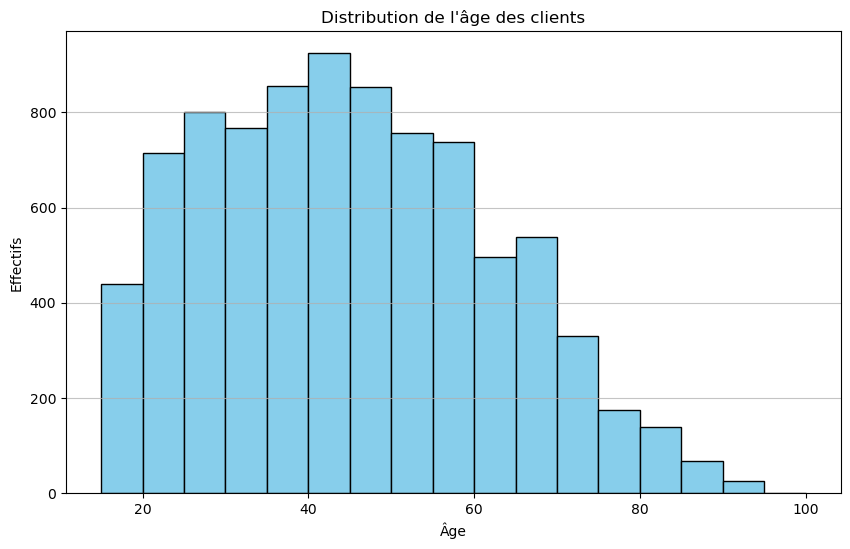

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df_clients['age'], bins=np.linspace(15,100,18), color='skyblue', edgecolor='black')
plt.title("Distribution de l'âge des clients")
plt.xlabel('Âge')
plt.ylabel('Effectifs')
plt.grid(axis='y', alpha=0.75)
plt.show()

Moyenne des âges : 44.7
Premier quartile des âges : 31.0
Médiane des âges : 44.0
Troisième quartile des âges : 57.0


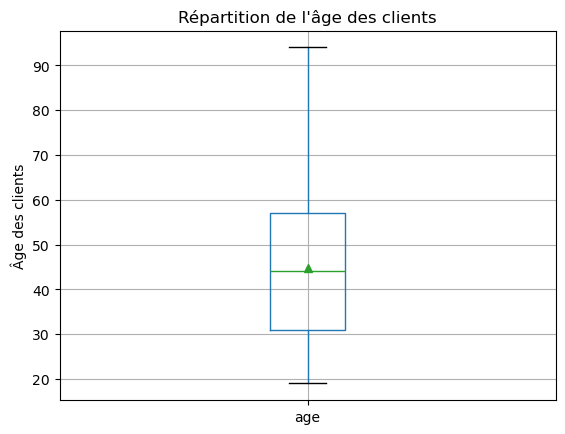

In [10]:
print("Moyenne des âges :",round(df_clients["age"].mean(),1))

print("Premier quartile des âges :",df_clients["age"].quantile(0.25))
print("Médiane des âges :",df_clients["age"].quantile(0.5))
print("Troisième quartile des âges :",df_clients["age"].quantile(0.75))

df_clients.boxplot(column=["age"],showmeans=True)
plt.ylabel("Âge des clients")
plt.title("Répartition de l'âge des clients")
plt.show()

La distribution des âges ne suit manifestement pas une loi normale. Vérifions cela avec le test de Shapiro-Wilk.<br>
Hypothèses :
- (H0) : les données suivent une distribution normale
- (H1) : les données ne suivent pas une distribution normale

Moyenne d'âge : 44.72
Écart type des âges : 16.92


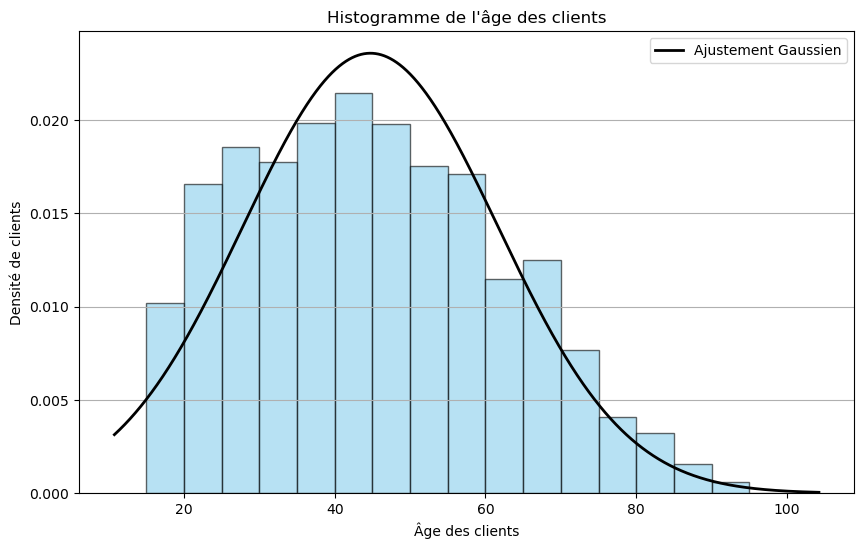

Statistique du test de Shapiro-Wilk : 0.9695972000522554
Valeur p : 3.573684571808415e-39
Les données ne suivent pas une distribution normale (on rejette H0)


C:\Users\nicol\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8621.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
data = df_clients['age'].sort_values()

# Estimer la moyenne et l'écart type
mean_age = data.mean()
std_age = data.std(ddof=1)    # Estimateur sans biais

# Afficher les valeurs calculées
print(f"Moyenne d'âge : {round(mean_age,2)}")
print(f"Écart type des âges : {round(std_age,2)}")

# Tracer l'histogramme avec une courbe gaussienne
plt.figure(figsize=(10, 6))

# Histogramme
plt.hist(data, bins=np.linspace(15,100,18), density=True, color='skyblue', edgecolor='black', alpha=0.6)

# Ajustement gaussien
mu, std = st.norm.fit(data)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, data.count())
p = st.norm.pdf(x, mu, std)

# Tracer la courbe gaussienne
plt.plot(x, p, 'k', linewidth=2, label='Ajustement Gaussien')

# Ajouter les titres et légendes en français
plt.title("Histogramme de l'âge des clients")
plt.xlabel('Âge des clients')
plt.ylabel('Densité de clients')
plt.legend()
plt.grid(axis='y')

# Afficher le graphique
plt.show()

# Test de Shapiro-Wilk
stat, p_value = st.shapiro(data)

# Afficher les résultats
print(f"Statistique du test de Shapiro-Wilk : {stat}")
print(f"Valeur p : {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (on ne rejette pas H0)")
else:
    print("Les données ne suivent pas une distribution normale (on rejette H0)")

Cela confirme ce qu'on pouvait visualier : les âges ne suivent pas une loi normale.

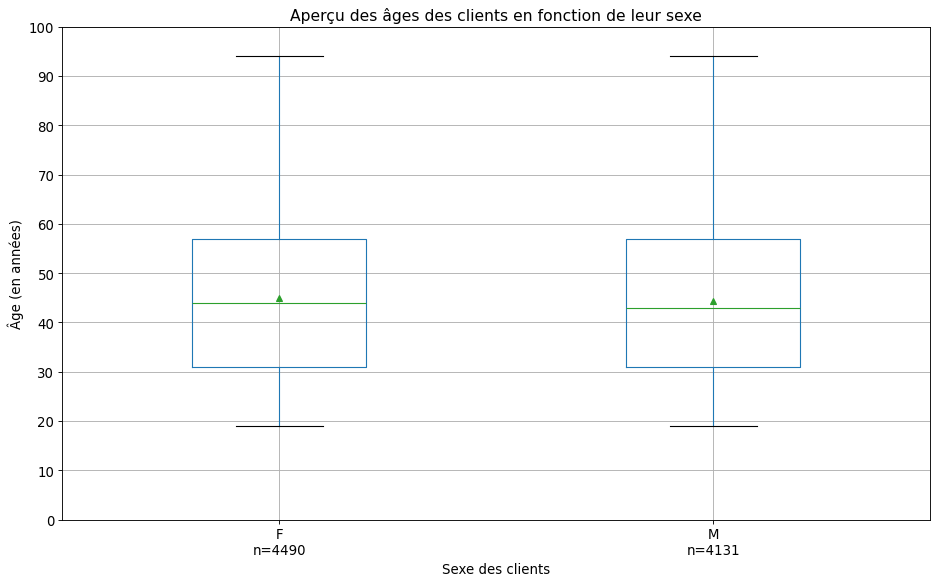

In [12]:
# Boîtes à moustaches pour l'analyse des âges selon le sexe des clients
L_sex = list(df_clients.groupby('sex').count().sort_values(by="client_id",ascending=False).index)

fig = plt.figure(figsize=(14,8), dpi=80)

for i in np.arange(len(L_sex)):
    sex = L_sex[i]
    df_clients.loc[df_clients["sex"] == sex].boxplot(column=["age"],\
                                                        positions=[i], widths=[0.4], showmeans=True)
    L_sex[i] = sex + "\n" + "n="+str(len(df_clients.loc[df_clients["sex"] == sex]))

plt.xticks(ticks=np.arange(len(L_sex)), labels=L_sex, fontsize=12)
plt.xlabel("Sexe des clients", fontsize=12)
plt.ylabel("Âge (en années)", fontsize=12)
plt.xlim([-0.5,len(L_sex)-0.5])
plt.ylim([0,100])
plt.yticks(ticks=np.linspace(0,100,11),fontsize=12)
plt.title("Aperçu des âges des clients en fonction de leur sexe", fontsize=14)
#plt.savefig("catprice.png")
plt.show()

Test U de Mann-Whitney (les âges ne suivent pas une loi normale) <br>
Hypothèse nulle testée :
- (H0) : la somme des rangs du groupe des clients F est analogue à la somme des rangs du groupe des clients M.

In [13]:
# Test U de Mann-Whitney pour déceler un éventuel effet statistque du sexe sur l'âge
# Hypothèse H0 : les âges des hommes et des femmes proviennent de la même distribution
U1, p = st.mannwhitneyu(df_clients.loc[df_clients["sex"] == 'F']["age"], df_clients.loc[df_clients["sex"] == 'M']["age"], method="auto")
nF, nM = (df_clients.loc[df_clients["sex"] == 'F']).shape[0], (df_clients.loc[df_clients["sex"] == 'M']).shape[0]
U2 = nF*nM - U1
print("U1 =",U1)
print("U2 =",U2)
print(f"Valeur p : {p}")

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("Les âges des femmes et des hommes proviennent de la même distribution (on ne rejette pas H0)")
else:
    print("Les âges des femmes et des hommes ne proviennent pas de la même distribution (on rejette H0)")

U1 = 9426833.5
U2 = 9121356.5
Valeur p : 0.18571753007715874
Les âges des femmes et des hommes proviennent de la même distribution (on ne rejette pas H0)


En supposant que les âges suivent une loi normale, on pourrait appliquer le test t de Student si les variances des distributions des âges pour chaque genre est proche.

In [14]:
Ages_F = df_clients.loc[df_clients["sex"] == 'F']["age"]
Ages_M = df_clients.loc[df_clients["sex"] == 'M']["age"]

VF = (Ages_F.std(ddof=1))**2
VM = (Ages_M.std(ddof=1))**2

print("Variance de la distribution des âges F :", VF)
print("Variance de la distribution des âges M :", VM)

Variance de la distribution des âges F : 292.2970658789277
Variance de la distribution des âges M : 279.4929744569929


On a un écart relatif inférieur à 5%. Examinons le résultat du test t de Student.<br>
Hypothèse H0 testée : les deux distributions ont une moyenne égale

In [15]:
# Calculer le test T et la valeur p
t_stat, p_value = st.ttest_ind(Ages_F, Ages_M, equal_var=False)  # Utilisation de equal_var=False par défaut

print(f"Statistique de test t : {t_stat}")
print(f"Valeur p : {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("La moyenne de la distribution des âges des clients F est égale à celle des âges des clients M (on ne rejette pas H0)")
else:
    print("La moyenne de la distribution des âges des clients F est différente de celles des âges des clients M (on rejette H0)")

Statistique de test t : 1.6372443570638366
Valeur p : 0.10161606422835723
La moyenne de la distribution des âges des clients F est égale à celle des âges des clients M (on ne rejette pas H0)


In [16]:
# Création de la variable tranche (d'âges)

df_clients["tranche"] = df_clients["age"].apply(lambda a: "19-31" if a<32 else ("52 et +" if a>51 else "32-51"))
display(df_clients)

display(df_clients.groupby("tranche").count())

,client_id,sex,age,tranche
0,c_4410,F,56,52 et +
1,c_7839,F,48,32-51
2,c_1699,F,39,32-51
3,c_5961,F,61,52 et +
4,c_5320,M,80,52 et +
...,...,...,...,...
8616,c_7920,M,67,52 et +
8617,c_7403,F,53,52 et +
8618,c_5119,M,49,32-51
8619,c_5643,F,55,52 et +


,client_id,sex,age
tranche,,,
19-31,2280,2280,2280
32-51,3366,3366,3366
52 et +,2975,2975,2975


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Analyse exploratoire des données produits</h3>
</div>

In [17]:
#Afficher les dimensions du dataset
print("Le tableau comporte {} observation(s) ou article(s)".format(df_products.shape[0]))
print("Le tableau comporte {} colonne(s)".format(df_products.shape[1]))

Le tableau comporte 3286 observation(s) ou article(s)
Le tableau comporte 3 colonne(s)


In [18]:
#Consulter le nombre de colonnes
print("Nombre de colonnes :", df_products.shape[1])
#La nature des données dans chacune des colonnes
display(df_products.dtypes)
#Le nombre de valeurs présentes dans chacune des colonnes
for c in list(df_products):
    print("\nColonne", c, "- Nombre de valeurs NaN :", ((df_products[c]).isna()).sum())
    print("Colonne", c, "- Nombre de valeurs non-vides :", df_products.shape[0] - ((df_products[c]).isna()).sum())

display(df_products)

Nombre de colonnes : 3


id_prod     object
price      float64
categ        int64
dtype: object


Colonne id_prod - Nombre de valeurs NaN : 0
Colonne id_prod - Nombre de valeurs non-vides : 3286

Colonne price - Nombre de valeurs NaN : 0
Colonne price - Nombre de valeurs non-vides : 3286

Colonne categ - Nombre de valeurs NaN : 0
Colonne categ - Nombre de valeurs non-vides : 3286


,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3281,2_23,115.99,2
3282,0_146,17.14,0
3283,0_802,11.22,0
3284,1_140,38.56,1


Types des données : *id_prod* et *categ* sont des données qualitatives, *price* est une donnée quantitative.

In [19]:
display((df_products.groupby(by="id_prod").count()).sort_values(by='categ',ascending=False))

,price,categ
id_prod,,
0_0,1,1
0_898,1,1
0_889,1,1
0_89,1,1
0_890,1,1
...,...,...
0_1986,1,1
0_1987,1,1
0_1988,1,1


Pas de doublon dans les données produits.

In [20]:
display(df_products.groupby(by="categ").count())
display(round(100*df_products.groupby(by="categ").count()/df_products.shape[0],1))

,id_prod,price
categ,,
0,2308,2308
1,739,739
2,239,239


,id_prod,price
categ,,
0,70.2,70.2
1,22.5,22.5
2,7.3,7.3


Environ 70% des produits du catalogue sont de la catégorie 0.<br>
Environ 22% des produits du catalogue sont de la catégorie 1.<br>
Environ 7% des produits du catalogue sont de la catégorie 2.<br>

In [21]:
print("Prix du produit le plus cher de notre catalogue :",max(df_products["price"]))
print("Prix du produit le moins cher de notre catalogue :",min(df_products["price"]))

Prix du produit le plus cher de notre catalogue : 300.0
Prix du produit le moins cher de notre catalogue : 0.62


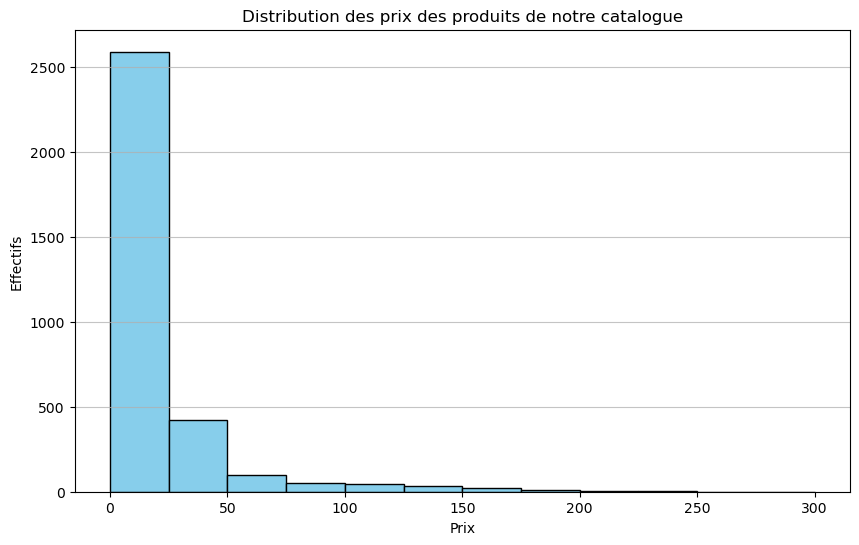

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df_products['price'], bins=np.linspace(0,300,13), color='skyblue', edgecolor='black')
plt.title("Distribution des prix des produits de notre catalogue")
plt.xlabel('Prix')
plt.ylabel('Effectifs')
plt.grid(axis='y', alpha=0.75)
plt.show()

Moyenne des prix : 21.86
Premier quartile des prix : 6.99
Prix médian : 13.075
Troisième quartile des prix : 22.99


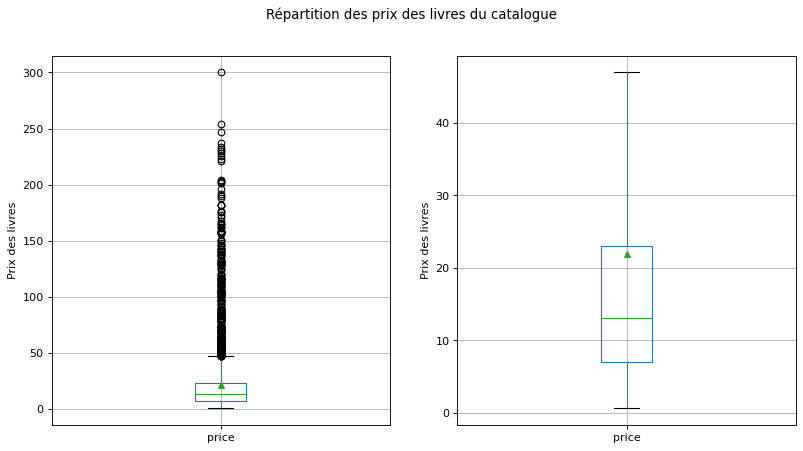


Nombre de livres avec un prix avec un prix atypique (au moins 47.0 €) :
 302


In [23]:
print("Moyenne des prix :",round(df_products["price"].mean(),2))

Q1 = df_products["price"].quantile(0.25)
Q3 = df_products["price"].quantile(0.75)

print("Premier quartile des prix :",Q1)
print("Prix médian :",df_products["price"].quantile(0.5))
print("Troisième quartile des prix :",Q3)

fig = plt.figure(figsize=(12,6), dpi=80)

plt.subplot(1,2,1)
df_products.boxplot(column=["price"],showmeans=True)
plt.ylabel("Prix des livres")

plt.subplot(1,2,2)
df_products.boxplot(column=["price"],showmeans=True,showfliers=False)
plt.ylabel("Prix des livres")

plt.suptitle("Répartition des prix des livres du catalogue")

plt.show()

print("\nNombre de livres avec un prix avec un prix atypique (au moins", 0.01+round(Q3+1.5*(Q3-Q1),2),"€) :\n", df_products.loc[df_products["price"]>=Q3+1.5*(Q3-Q1)].shape[0])

La distribution des prix ne suit manifestement pas une loi normale. Vérifions cela avec le test de Shapiro-Wilk.<br>
Hypothèses :
- (H0) : les données suivent une distribution normale
- (H1) : les données ne suivent pas une distribution normale

In [24]:
data = df_products["price"]

# Test de Shapiro-Wilk
stat, p_value = st.shapiro(data)

# Afficher les résultats
print(f"Statistique du test de Shapiro-Wilk : {stat}")
print(f"Valeur p : {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (on ne rejette pas H0)")
else:
    print("Les données ne suivent pas une distribution normale (on rejette H0)")

Statistique du test de Shapiro-Wilk : 0.5730601668202504
Valeur p : 3.1215044190747844e-67
Les données ne suivent pas une distribution normale (on rejette H0)


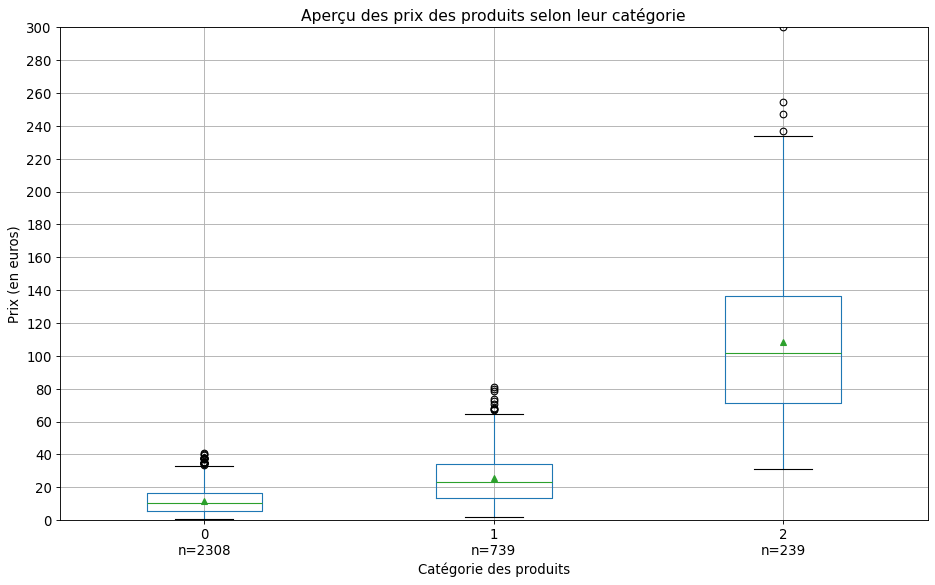

In [25]:
# Boîtes à moustaches pour l'analyse des prix selon la catégorie des produits
L_cat = list(df_products.groupby('categ').count().sort_values(by="id_prod",ascending=False).index)

fig = plt.figure(figsize=(14,8), dpi=80)

for i in np.arange(len(L_cat)):
    cat = L_cat[i]
    df_products.loc[df_products["categ"] == cat].boxplot(column=["price"],\
                                                        positions=[i], widths=[0.4], showmeans=True)
    L_cat[i] = str(cat) + "\n" + "n="+str(len(df_products.loc[df_products["categ"] == cat]))

plt.xticks(ticks=np.arange(len(L_cat)), labels=L_cat, fontsize=12)
plt.xlabel("Catégorie des produits", fontsize=12)
plt.ylabel("Prix (en euros)", fontsize=12)
plt.xlim([-0.5,len(L_cat)-0.5])
plt.ylim([0,300])
plt.yticks(ticks=np.linspace(0,300,16),fontsize=12)
plt.title("Aperçu des prix des produits selon leur catégorie", fontsize=14)
plt.savefig("catprice.png")
plt.show()

In [26]:
# Test H de Kruskal-Wallis pour déceler un éventuel effet statistque de la catégorie sur le prix des produits
# Hypothèse H0 : Les prix des produits des catégories 0, 1 et 2 proviennent de la même distribution
# Hypothèse H1 : la catégorie a une influence directe sur le prix des produits
   

H, p = st.kruskal(df_products.loc[df_products["categ"] == 0]["price"],\
                     df_products.loc[df_products["categ"] == 1]["price"],\
                     df_products.loc[df_products["categ"] == 2]["price"])

print("Statistique H =",H)
print(f"Valeur p : {p}")

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("Les prix des différentes catégories proviennent de la même distribution (on ne rejette pas H0)")
else:
    print("Les prix des différentes catégories ne proviennent pas de la même distribution (on rejette H0)")

Statistique H = 1133.3265102652797
Valeur p : 7.966640110783833e-247
Les prix des différentes catégories ne proviennent pas de la même distribution (on rejette H0)


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.3 - Analyse exploratoire des données de transaction</h3>
</div>

In [27]:
#Afficher les dimensions du dataset
print("Le tableau comporte {} observation(s) ou article(s)".format(df_ventes.shape[0]))
print("Le tableau comporte {} colonne(s)".format(df_ventes.shape[1]))

Le tableau comporte 1048575 observation(s) ou article(s)
Le tableau comporte 4 colonne(s)


In [28]:
#Consulter le nombre de colonnes
print("Nombre de colonnes :", df_ventes.shape[1])
#La nature des données dans chacune des colonnes
display(df_ventes.dtypes)
#Le nombre de valeurs présentes dans chacune des colonnes
for c in list(df_ventes):
    print("\nColonne", c, "- Nombre de valeurs NaN :", ((df_ventes[c]).isna()).sum())
    print("Colonne", c, "- Nombre de valeurs non-vides :", df_ventes.shape[0] - ((df_ventes[c]).isna()).sum())

display(df_ventes)

Nombre de colonnes : 4


id_prod       object
date          object
session_id    object
client_id     object
dtype: object


Colonne id_prod - Nombre de valeurs NaN : 361041
Colonne id_prod - Nombre de valeurs non-vides : 687534

Colonne date - Nombre de valeurs NaN : 361041
Colonne date - Nombre de valeurs non-vides : 687534

Colonne session_id - Nombre de valeurs NaN : 361041
Colonne session_id - Nombre de valeurs non-vides : 687534

Colonne client_id - Nombre de valeurs NaN : 361041
Colonne client_id - Nombre de valeurs non-vides : 687534


,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
1048570,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN


In [29]:
df_ventes.dropna(axis=0,inplace=True)

print("Le tableau comporte {} observation(s) ou article(s)".format(df_ventes.shape[0]))
print("Le tableau comporte {} colonne(s)".format(df_ventes.shape[1]))

display(df_ventes.dtypes)

for c in list(df_ventes):
    print("\nColonne", c, "- Nombre de valeurs NaN :", ((df_ventes[c]).isna()).sum())
    print("Colonne", c, "- Nombre de valeurs non-vides :", df_ventes.shape[0] - ((df_ventes[c]).isna()).sum())

display(df_ventes)

Le tableau comporte 687534 observation(s) ou article(s)
Le tableau comporte 4 colonne(s)


id_prod       object
date          object
session_id    object
client_id     object
dtype: object


Colonne id_prod - Nombre de valeurs NaN : 0
Colonne id_prod - Nombre de valeurs non-vides : 687534

Colonne date - Nombre de valeurs NaN : 0
Colonne date - Nombre de valeurs non-vides : 687534

Colonne session_id - Nombre de valeurs NaN : 0
Colonne session_id - Nombre de valeurs non-vides : 687534

Colonne client_id - Nombre de valeurs NaN : 0
Colonne client_id - Nombre de valeurs non-vides : 687534


,id_prod,date,session_id,client_id
0,0_1259,2021-03-01 00:01:07.843138,s_1,c_329
1,0_1390,2021-03-01 00:02:26.047414,s_2,c_664
2,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
3,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
4,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573
687530,2_37,2023-02-28 23:51:29.318531,s_348445,c_50
687531,1_695,2023-02-28 23:53:18.929676,s_348446,c_488
687532,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848


In [30]:
df_ventes_oct2021 = df_ventes.copy()
df_ventes_oct2021["mois"] = df_ventes_oct2021['date'].apply(lambda s: s[0:7])
df_ventes_oct2021 = df_ventes_oct2021.loc[df_ventes_oct2021["mois"]=="2021-10"].copy()
df_ventes_oct2021 = df_ventes_oct2021.sort_values("date")
df_ventes_oct2021.to_csv("ventesoct2021.csv", sep=';')

In [31]:
# On ne conserve que le jour de la transaction
df_ventes["date"] = df_ventes["date"].apply(lambda s: s[0:10])
df_ventes.to_csv("ventes.csv", sep=';')
display(df_ventes)

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01,s_1,c_329
1,0_1390,2021-03-01,s_2,c_664
2,0_1352,2021-03-01,s_3,c_580
3,0_1458,2021-03-01,s_4,c_7912
4,0_1358,2021-03-01,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28,s_348444,c_3573
687530,2_37,2023-02-28,s_348445,c_50
687531,1_695,2023-02-28,s_348446,c_488
687532,0_1547,2023-02-28,s_348447,c_4848


In [32]:
# /!\ Dates au format AAAA-MM-JJ
print("Les données couvrent une période allant du",min(df_ventes["date"]),"au",max(df_ventes["date"]))

Les données couvrent une période allant du 2021-03-01 au 2023-02-28


In [33]:
print("Sur la période étudiée :")
print("- Nombre de produits différents vendus :",len(df_ventes["id_prod"].unique()))
print("- Nombre de sessions d'achat :",len(df_ventes["session_id"].unique()))
print("- Nombre de clients différents ayant effectué au moins un achat :",len(df_ventes["client_id"].unique()))

Sur la période étudiée :
- Nombre de produits différents vendus : 3265
- Nombre de sessions d'achat : 345505
- Nombre de clients différents ayant effectué au moins un achat : 8600


In [34]:
# Y-a-t-il des sessions qui se sont étalées sur plus d'un jour calendaire ?
df_test = (df_ventes.groupby(["session_id","date"]).count().reset_index()).drop(axis=1, columns=["id_prod","client_id"])
df_test = (df_test.groupby("session_id").count()).sort_values("date",ascending=False)
print("Nombre de sessions étalées sur plus d'un jour :",(df_test.loc[df_test["date"]>1]).shape[0])

Nombre de sessions étalées sur plus d'un jour : 1587


In [35]:
# Y-a-t-il des clients qui ont acheté plus d'une fois un même produit ?
df_client_prod = df_ventes.groupby(["client_id","id_prod"]).count().reset_index().drop(axis=1, columns=["session_id"])
df_client_prod.rename(columns={"date": "sales_qty"}, inplace=True)
display(df_client_prod.sort_values(by="sales_qty", ascending=False))

,client_id,id_prod,sales_qty
24885,c_1609,0_1438,95
159253,c_4958,2_39,94
159251,c_4958,2_37,93
159122,c_4958,2_110,89
159120,c_4958,2_109,85
...,...,...,...
221677,c_6467,1_636,1
221676,c_6467,1_62,1
133203,c_4309,0_1373,1
133205,c_4309,0_1380,1


In [36]:
df_test = df_client_prod.loc[df_client_prod["sales_qty"]>1]
#print(sum(df_test["sales_qty"]))
print("Nombre de clients ayant acheté au moins 2 fois un même produit :",len(df_test["client_id"].unique()))
print("Liste des clients ayant acheté au moins 2 fois le même produit :")
display(df_test.sort_values(by="sales_qty", ascending=False))

Nombre de clients ayant acheté au moins 2 fois un même produit : 8525
Liste des clients ayant acheté au moins 2 fois le même produit :


,client_id,id_prod,sales_qty
24885,c_1609,0_1438,95
159253,c_4958,2_39,94
159251,c_4958,2_37,93
159122,c_4958,2_110,89
159120,c_4958,2_109,85
...,...,...,...
156188,c_4894,1_271,2
156187,c_4894,0_2283,2
156186,c_4894,0_1639,2
156185,c_4894,0_1580,2


L'écrasante majorité (8525/8600 ~ 99%) des clients ayant fait au moins un achat sur la période d'étude ont acheté au moins 2 fois un même produit. Pour des produits culturellement "uniques" comme des livres, cela est déroutant.<br>
Soit l'essentiel des clients est en fait des entreprises (les notions de genre et d'âge des clients devenant un peu plus floues), soit les produits vendus ne sont en réalité pas des livres mais des biens de consommation plus courants ce qui semble plus probable compte tenu du résultat précdent.

In [37]:
# 10 Produits les plus vendus en quantité sur toute la période
df_SalesQty = df_ventes.groupby("id_prod")["session_id"].count().reset_index()
df_SalesQty.rename(columns={"session_id": "sales_qty"}, inplace=True)
display(df_SalesQty.sort_values(by="sales_qty", ascending=False).head(10))

,id_prod,sales_qty
2591,1_369,2340
2644,1_417,2269
2641,1_414,2246
2733,1_498,2202
2653,1_425,2163
2629,1_403,2040
2640,1_413,2036
2639,1_412,2014
2632,1_406,2003
2633,1_407,2001


In [38]:
# Clients ayant réalisé le plus de sessions d'achat sur toute la période
df_Sessions_Clients = ((df_ventes[["client_id","session_id"]]).groupby("client_id")["session_id"].nunique()).reset_index()
df_Sessions_Clients.rename(columns={"session_id": "nb_sessions"}, inplace=True)
df_Sessions_Clients = df_clients.merge(df_Sessions_Clients, how="left", left_on="client_id", right_on="client_id")
df_Sessions_Clients = df_Sessions_Clients.fillna(0)
df_Sessions_Clients = df_Sessions_Clients.astype({"nb_sessions": "int64"})
display((df_Sessions_Clients.sort_values(by="nb_sessions",ascending=False)).head(10))
print("Rappel - Nombre total de sessions d'achat sur toute la période :",\
      sum(df_Sessions_Clients["nb_sessions"]))

,client_id,sex,age,tranche,nb_sessions
3641,c_1609,M,43,32-51,10997
8087,c_3454,M,54,52 et +,5571
1378,c_4958,M,24,19-31,3851
1911,c_6714,F,55,52 et +,2620
942,c_8526,F,58,52 et +,167
3005,c_1637,F,35,32-51,165
8300,c_2265,M,55,52 et +,165
8279,c_669,M,35,32-51,163
2057,c_8510,M,32,32-51,162
2097,c_682,F,49,32-51,161


Rappel - Nombre total de sessions d'achat sur toute la période : 345505


Les clients c_1609, c_3454, c_4958 et c_6714 se détachent des autres clients avec un nombre de sessions d'achats bien au-delà de 1000.<br>
Examinons la distribution des nombres de sessions d'achats par client.

Nombre moyen de sessions par client : 40.1
Premier quartile des nombres de sessions : 15.0
Médiane des nombres de sessions : 27.0
Troisième quartile des nombres de sessions : 50.0

Nombre de clients avec un nombre de sessions atypique (au moins 102 ) : 457

Nombre de clients avec un nombre de sessions très atypique (au moins 190 ) : 4 



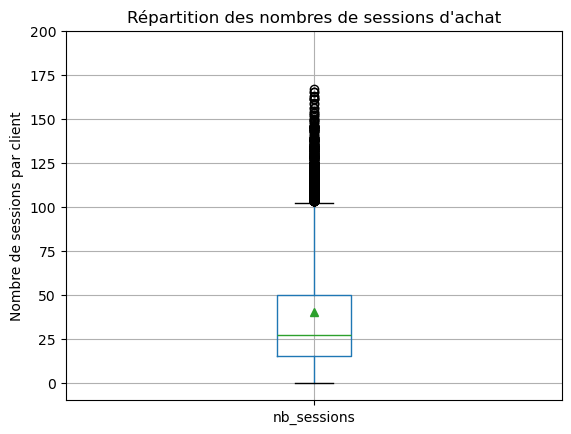

In [39]:
print("Nombre moyen de sessions par client :",round(df_Sessions_Clients["nb_sessions"].mean(),1))

Q1 = round(df_Sessions_Clients["nb_sessions"].quantile(0.25),2)
Q3 = round(df_Sessions_Clients["nb_sessions"].quantile(0.75),2)

print("Premier quartile des nombres de sessions :",Q1)
print("Médiane des nombres de sessions :",round(df_Sessions_Clients["nb_sessions"].quantile(0.5),2))
print("Troisième quartile des nombres de sessions :",Q3)

print("\nNombre de clients avec un nombre de sessions atypique (au moins",\
      int(round(Q3+1.5*(Q3-Q1),0)),") :",\
      df_Sessions_Clients.loc[df_Sessions_Clients["nb_sessions"]>=Q3+1.5*(Q3-Q1)].shape[0])

print("\nNombre de clients avec un nombre de sessions très atypique (au moins",\
      int(round(Q3+4*(Q3-Q1),0)),") :",\
      df_Sessions_Clients.loc[df_Sessions_Clients["nb_sessions"]>=Q3+4*(Q3-Q1)].shape[0],"\n")

df_Sessions_Clients.boxplot(column=["nb_sessions"],showmeans=True)
plt.ylabel("Nombre de sessions par client")
plt.ylim([-10,200])
plt.title("Répartition des nombres de sessions d'achat")
plt.show()

La distribution des nombres de sessions d'achat ne suit manifestement pas une loi normale. Vérifions cela avec le test de Shapiro-Wilk.<br>
Hypothèses :
- (H0) : les données suivent une distribution normale
- (H1) : les données ne suivent pas une distribution normale

In [40]:
# On enlève les clients BtoB (nb_sessions > 1000)
data = df_Sessions_Clients.loc[df_Sessions_Clients['nb_sessions']<1e3]['nb_sessions']

# Estimer la moyenne et l'écart type
mean_CA = data.mean()
std_CA = data.std(ddof=1)    # Estimateur sans biais

# Afficher les valeurs calculées
print(f"Nombre moyen de sessions par client : {round(mean_CA,1)}")
print(f"Écart type des nombres de sessions : {round(std_CA,1)}")

# Test de Shapiro-Wilk
stat, p_value = st.shapiro(data)

# Afficher les résultats
print(f"Statistique du test de Shapiro-Wilk : {stat}")
print(f"Valeur p : {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (on ne rejette pas H0)")
else:
    print("Les données ne suivent pas une distribution normale (on rejette H0)")

Nombre moyen de sessions par client : 37.4
Écart type des nombres de sessions : 30.9
Statistique du test de Shapiro-Wilk : 0.8583758065689213
Valeur p : 3.5980400166608375e-66
Les données ne suivent pas une distribution normale (on rejette H0)


C:\Users\nicol\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8617.
  res = hypotest_fun_out(*samples, **kwds)


In [41]:
# Clients ayant acheté le plus de produits sur toute la période :
df_NbAchats_Clients = (df_ventes.groupby("client_id")["id_prod"].count()).reset_index()
df_NbAchats_Clients.rename(columns={"id_prod": "nb_achats"}, inplace=True)
display((df_NbAchats_Clients.sort_values(by="nb_achats", ascending=False)).head(10))
print("Rappel - Nombre total de produits vendus sur toute la période :",\
      sum(df_NbAchats_Clients["nb_achats"]))

,client_id,nb_achats
677,c_1609,25586
6337,c_6714,9199
2724,c_3454,6793
4388,c_4958,5222
1268,c_2140,405
2513,c_3263,403
1772,c_2595,398
1197,c_2077,386
708,c_1637,384
7120,c_7421,381


Rappel - Nombre total de produits vendus sur toute la période : 687534


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.4 - Export données complètes</h3>
</div>

In [42]:
df_data = df_ventes.merge(df_clients, how="inner", left_on="client_id", right_on="client_id")
df_data = df_data.merge(df_products, how="inner", left_on="id_prod", right_on="id_prod")

df_data.to_csv("data.csv", sep=';', index=False)

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 3 - Analyse des ventes et du chiffre d'affaires</h2>
</div>

Les données de transactions ne donnent que les quantités de produits vendues ainsi que les dates d'achat.<br>
Les données de prix et de catégorie des produits n'apparaissent que dans les données produits.<br>
Il faut donc réaliser une jointure en utilisant l'égalité entre les *id_prod* des 2 DataFrames comme condition de jointure.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1 - Analyses globales sur l'ensemble de la période</h3>
</div>

Pour ces analyses globales, les données temporelles ne sont pas nécessaires.

Une jointure interne n'est pas suffisante car les produits du catalogue qui n'ont pas été vendus n'apparaissent pas dans les transactions.<br>
En toute généralité, une jointure externe permettrait de vérifier que tous les produits vendus sont bien référencés dans le catalogue.<br>
Avec des données propres, une jointure à gauche des données produits suffirait pour les besoins de notre analyse.

In [43]:
df_CA = df_products.merge(df_client_prod,how='outer',left_on='id_prod',right_on='id_prod')
df_CA = df_CA[["client_id","id_prod","price","categ","sales_qty"]]
display(df_CA)

,client_id,id_prod,price,categ,sales_qty
0,c_1004,0_0,3.75,0,1.0
1,c_1011,0_0,3.75,0,4.0
2,c_1020,0_0,3.75,0,3.0
3,c_1037,0_0,3.75,0,4.0
4,c_1052,0_0,3.75,0,2.0
...,...,...,...,...,...
314737,c_4958,2_97,160.99,2,2.0
314738,c_5899,2_97,160.99,2,3.0
314739,c_5967,2_98,149.74,2,1.0
314740,c_5828,2_99,84.99,2,4.0


*NaN* dans la colonne *price* (ou *categ*) => Produit vendu mais non-référencé => **Mettre à jour données produits**

*NaN* dans la colonne *sales_qty* (ou *client_id*) => Produit référencé mais non-vendu => **Remplacer sales_qty par 0**

In [44]:
print("Nombre de produits vendus non-référencés :", ((df_CA["id_prod"]).isna()).sum())
print("Nombre de références distinctes qui n'ont pas été vendues :", ((df_CA["sales_qty"]).isna()).sum())

Nombre de produits vendus non-référencés : 0
Nombre de références distinctes qui n'ont pas été vendues : 21


In [45]:
df_CA["sales_qty"] = df_CA["sales_qty"].fillna(0)
df_CA = df_CA.astype({"sales_qty": "int64"})
df_CA["CA"] = df_CA["price"]*df_CA["sales_qty"]
CA_total = df_CA["CA"].sum()
total_ventes = df_CA["sales_qty"].sum()
print("CA total sur l'ensemble de la période :",round(CA_total,2),"€")
print("Nombre total de produits vendus :",total_ventes)

CA total sur l'ensemble de la période : 12027663.1 €
Nombre total de produits vendus : 687534


In [46]:
# Création d'un DataFrame associant les catégories de produits à des couleurs
couleurs = {"categ": [0,1,2],
           "couleur": ["tab:blue","tab:green","tab:red"]}
df_couleurs = pd.DataFrame(data=couleurs)
display(df_couleurs)

,categ,couleur
0,0,tab:blue
1,1,tab:green
2,2,tab:red


<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1.1 - CA et ventes par catégorie de produit</h4>
</div>

,CA
categ,
0,4419730.97
1,4827657.11
2,2780275.02


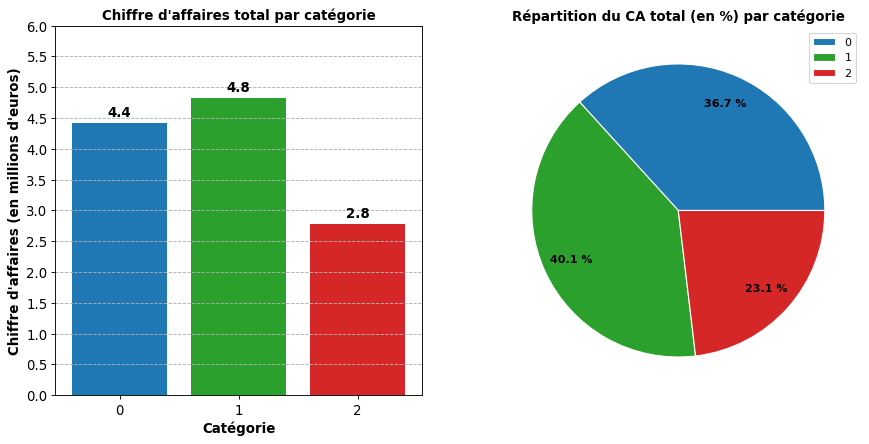

In [47]:
#CA par catégories de produits
df_CAcat = (df_CA.groupby('categ')[["CA"]].sum()).sort_values("categ",ascending=True)

display(df_CAcat)

#Affichage graphique : diagramme en secteurs
fig = plt.figure(figsize=(13,6), dpi=80)

plt.subplot(1,2,1)
p=plt.bar(df_CAcat.index, df_CAcat['CA']/1e6, color=df_couleurs["couleur"])
plt.bar_label(p, label_type='edge', fmt='%.1f', padding=3.0, fontsize=12, fontweight='bold')
plt.xlabel("Catégorie", fontsize=12, fontweight='heavy')
plt.ylabel("Chiffre d'affaires (en millions d'euros)", fontsize=12, fontweight='heavy')
plt.ylim([0,6])
plt.title("Chiffre d'affaires total par catégorie", fontsize=12, fontweight='heavy')
plt.xticks(np.linspace(0,2,3),fontsize=12)
plt.yticks(np.linspace(0,6.0,13),fontsize=12)
plt.grid(visible=True, axis='y', linestyle='--')

plt.subplot(1,2,2)
plt.pie(df_CAcat["CA"],\
        colors=(df_CAcat.merge(df_couleurs, how="inner", left_index=True, right_on="categ"))["couleur"],\
        pctdistance=0.8,\
        wedgeprops={'edgecolor': 'w'},\
        autopct=lambda x: f"{x:.1f} %",\
        textprops={'fontweight': 'bold'})
plt.legend(list(df_CAcat.index), loc='best')
plt.title("Répartition du CA total (en %) par catégorie", fontsize=12, fontweight='heavy')
plt.savefig("Rep_CA_categorie.png")
plt.show()

Quantités totales vendues sur l'ensemble de la période : 687534


,sales_qty
categ,
0,415459
1,235592
2,36483


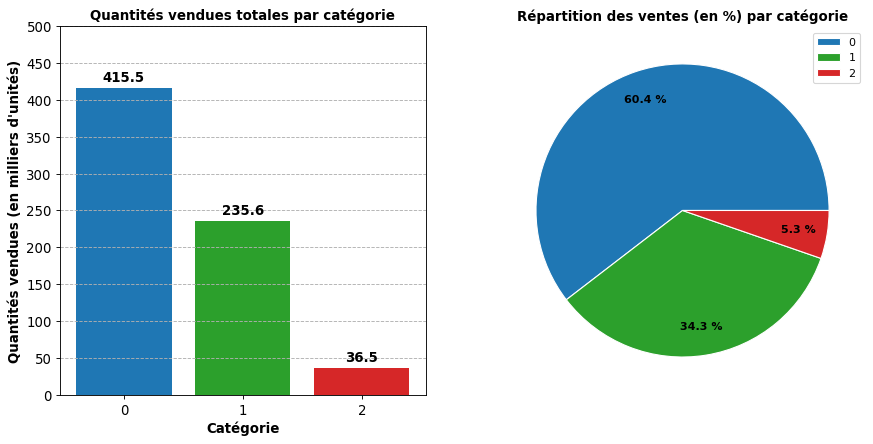

In [48]:
#Quantités de produits vendus par catégories de produits
df_Qtcat = (df_CA.groupby('categ')[["sales_qty"]].sum()).sort_values("categ",ascending=True)

print("Quantités totales vendues sur l'ensemble de la période :",df_Qtcat["sales_qty"].sum())

display(df_Qtcat)

#Affichage graphique : diagramme en secteurs
fig = plt.figure(figsize=(13,6), dpi=80)

plt.subplot(1,2,1)
p=plt.bar(df_Qtcat.index, df_Qtcat['sales_qty']/1e3, color=df_couleurs["couleur"])
plt.bar_label(p, label_type='edge', fmt='%.1f', padding=3.0, fontsize=12, fontweight='bold')
plt.xlabel("Catégorie", fontsize=12, fontweight='heavy')
plt.ylabel("Quantités vendues (en milliers d'unités)", fontsize=12, fontweight='heavy')
plt.ylim([0,500])
plt.title("Quantités vendues totales par catégorie", fontsize=12, fontweight='heavy')
plt.xticks(np.linspace(0,2,3),fontsize=12)
plt.yticks(np.linspace(0,500,11),fontsize=12)
plt.grid(visible=True, axis='y', linestyle='--')

plt.subplot(1,2,2)
plt.pie(df_Qtcat["sales_qty"],\
        colors=(df_Qtcat.merge(df_couleurs, how="inner", left_index=True, right_on="categ"))["couleur"],\
        pctdistance=0.8,\
        wedgeprops={'edgecolor': 'w'},\
        autopct=lambda x: f"{x:.1f} %",\
        textprops={'fontweight': 'bold'})
plt.legend(list(df_Qtcat.index), loc='best')
plt.title("Répartition des ventes (en %) par catégorie", fontsize=12, fontweight='heavy')
plt.savefig("Rep_Qt_categorie.png")
plt.show()

In [49]:
df_CA0 = df_CA.loc[df_CA["sales_qty"]==0]
df_CA0 = df_CA0.drop(["client_id"],axis=1)
print("Liste des",df_CA0.shape[0],"produits qui n'ont pas été vendus sur toute la période :")
display(df_CA0)

Liste des 21 produits qui n'ont pas été vendus sur toute la période :


,id_prod,price,categ,sales_qty,CA
2759,0_1014,1.15,0,0,0.0
2975,0_1016,35.06,0,0,0.0
4011,0_1025,24.99,0,0,0.0
10028,0_1062,20.08,0,0,0.0
18943,0_1119,2.99,0,0,0.0
43839,0_1318,20.92,0,0,0.0
134380,0_1620,0.80,0,0,0.0
135344,0_1624,24.50,0,0,0.0
140782,0_1645,2.99,0,0,0.0
146573,0_1780,1.67,0,0,0.0


In [50]:
df_CAprod = (df_CA.groupby(["id_prod","categ","price"])[["sales_qty","CA"]].sum()).reset_index()
display(df_CAprod)

,id_prod,categ,price,sales_qty,CA
0,0_0,0,3.75,1242,4657.50
1,0_1,0,10.99,487,5352.13
2,0_10,0,17.95,22,394.90
3,0_100,0,20.60,3,61.80
4,0_1000,0,6.84,432,2954.88
...,...,...,...,...,...
3281,2_95,2,98.99,4,395.96
3282,2_96,2,47.91,598,28650.18
3283,2_97,2,160.99,13,2092.87
3284,2_98,2,149.74,1,149.74


<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1.2 - CA et ventes : produits les plus performants</h4>
</div>

In [51]:
#############################
# Top 20 des articles en CA #
#############################

#Effectuer le tri par ordre décroissant de CA
df_CAprod.sort_values("CA", ascending=False,inplace=True)
#Réinitialiser l'index du dataset par un reset_index
df_CAprod.reset_index(inplace=True,drop=True)
#Afficher les 20 premiers articles en CA
df_20CAprod = (df_CAprod.loc[:,["id_prod","categ","sales_qty","CA"]]).head(20)
display(df_20CAprod)

,id_prod,categ,sales_qty,CA
0,2_159,2,650,94893.50
1,2_135,2,1005,69334.95
2,2_112,2,968,65407.76
3,2_102,2,1027,60736.78
4,2_209,2,814,56971.86
5,1_395,1,1953,56617.47
6,1_369,1,2340,56136.60
7,2_110,2,865,53846.25
8,1_383,1,1857,53834.43
9,1_414,1,2246,53522.18


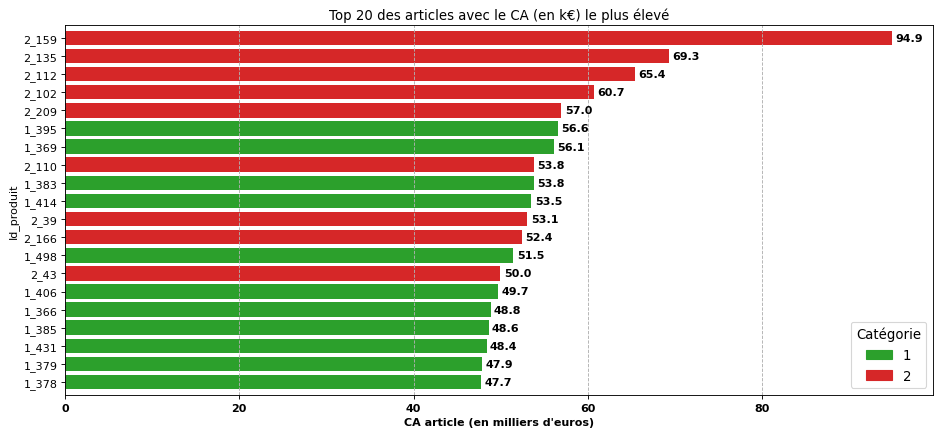

In [52]:
#Graphique avec pyplot
fig = plt.figure(figsize=(14,6), dpi=80)

df_20CAprod.sort_values("CA", ascending=True,inplace=True)
df_20CAprod.reset_index(inplace=True)

df_color_data = (df_20CAprod.merge(df_couleurs, how="inner", left_on="categ", right_on="categ"))

p=plt.barh(1+np.arange(df_20CAprod.shape[0]),
           df_20CAprod['CA']/1e3,
           tick_label=df_20CAprod['id_prod'],
           color=df_color_data["couleur"])
plt.bar_label(p, label_type='edge', fmt='%.1f', padding=3.0, fontsize=10, fontweight='bold')
plt.grid(visible=True, axis='x', linestyle='--')
plt.xlabel("CA article (en milliers d'euros)",fontweight='bold')
plt.xticks(fontweight='bold')
plt.ylabel("Id_produit")
plt.ylim([0.3,20.7])

# Utilisation de patches pour faire une légende propre
cat_couleurs = df_color_data.set_index("categ")["couleur"].to_dict()
patches = [mpatches.Patch(color=couleur, label=cat) for cat, couleur in cat_couleurs.items()]
plt.legend(handles=patches, title="Catégorie", title_fontsize=12, loc="best", fontsize=12)

plt.title("Top 20 des articles avec le CA (en k€) le plus élevé")
plt.savefig("Top20_CA.png")

plt.show()

,id_prod,categ,sales_qty,CA
3245,0_902,0,4,3.68
3246,0_324,0,3,3.54
3247,0_549,0,1,2.99
3248,0_833,0,1,2.99
3249,0_1379,0,1,2.99
3250,0_1683,0,1,2.99
3251,0_1151,0,1,2.99
3252,0_643,0,3,2.97
3253,0_1191,0,3,2.97
3254,0_1759,0,3,2.97


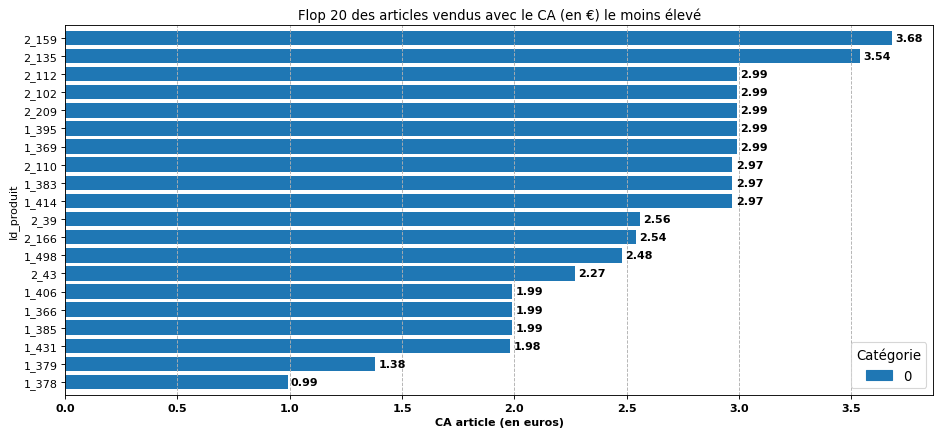

In [53]:
##############################
# Flop 20 des articles en CA #
##############################

#Afficher les 20 premiers articles en CA
df_f20CAprod = (df_CAprod.loc[df_CAprod["CA"]>0,["id_prod","categ","sales_qty","CA"]]).tail(20)
display(df_f20CAprod)

#Graphique avec pyplot
fig = plt.figure(figsize=(14,6), dpi=80)

df_f20CAprod.sort_values("CA", ascending=True, inplace=True)
df_f20CAprod.reset_index(inplace=True)

df_color_data = (df_f20CAprod.merge(df_couleurs, how="inner", left_on="categ", right_on="categ"))

p=plt.barh(1+np.arange(df_f20CAprod.shape[0]),
           df_f20CAprod['CA'],
           tick_label=df_20CAprod['id_prod'],
           color=df_color_data["couleur"])
plt.bar_label(p, label_type='edge', fmt='%.2f', padding=3.0, fontsize=10, fontweight='bold')
plt.grid(visible=True, axis='x', linestyle='--')
plt.xlabel("CA article (en euros)",fontweight='bold')
plt.xticks(fontweight='bold')
plt.ylabel("Id_produit")
plt.ylim([0.3,20.7])

# Utilisation de patches pour faire une légende propre
cat_couleurs = df_color_data.set_index("categ")["couleur"].to_dict()
patches = [mpatches.Patch(color=couleur, label=cat) for cat, couleur in cat_couleurs.items()]
plt.legend(handles=patches, title="Catégorie", title_fontsize=12, loc="best", fontsize=12)

plt.title("Flop 20 des articles vendus avec le CA (en €) le moins élevé")
plt.savefig("Flop20_CA.png")

plt.show()

In [54]:
######################################
# Palmares des articles en quantités #
######################################

#Effectuer le tri dans l'ordre décroissant de quantités vendues du dataset df_merge
df_CAprod.sort_values("sales_qty", ascending=False,inplace=True)
#Réinitialiser l'index du dataset par un reset_index
df_CAprod.reset_index(inplace=True, drop=True)
#Afficher les 20 premiers articles en quantité
df_20BSprod = (df_CAprod.loc[:,["id_prod","categ","sales_qty","CA"]]).head(20)
display(df_20BSprod)

,id_prod,categ,sales_qty,CA
0,1_369,1,2340,56136.60
1,1_417,1,2269,47626.31
2,1_414,1,2246,53522.18
3,1_498,1,2202,51460.74
4,1_425,1,2163,36749.37
5,1_403,1,2040,36699.60
6,1_413,1,2036,36627.64
7,1_412,1,2014,33533.10
8,1_406,1,2003,49694.43
9,1_407,1,2001,31995.99


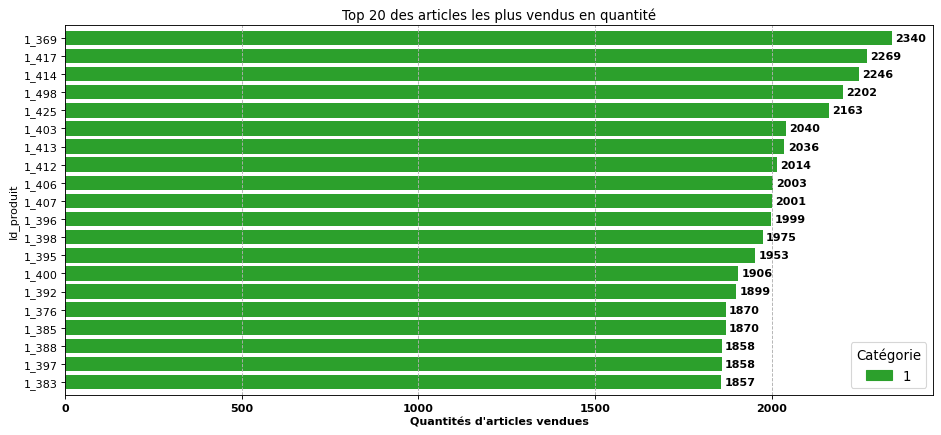

In [55]:
#Graphique avec pyplot
fig = plt.figure(figsize=(14,6), dpi=80)

df_20BSprod.sort_values("sales_qty", ascending=True,inplace=True)
df_20BSprod.reset_index(inplace=True)

df_color_data = (df_20BSprod.merge(df_couleurs, how="inner", left_on="categ", right_on="categ"))

p=plt.barh(1+np.arange(df_20BSprod.shape[0]),
           df_20BSprod['sales_qty'],
           tick_label=df_20BSprod['id_prod'],
           color=df_color_data["couleur"])
plt.bar_label(p, label_type='edge', fmt='%d', padding=3.0, fontsize=10, fontweight='bold')
plt.grid(visible=True, axis='x', linestyle='--')
plt.xlabel("Quantités d'articles vendues",fontweight='bold')
plt.xticks(fontweight='bold')
plt.ylabel("Id_produit")
plt.ylim([0.3,20.7])

# Utilisation de patches pour faire une légende propre
cat_couleurs = df_color_data.set_index("categ")["couleur"].to_dict()
patches = [mpatches.Patch(color=couleur, label=cat) for cat, couleur in cat_couleurs.items()]
plt.legend(handles=patches, title="Catégorie", title_fontsize=12, loc="best", fontsize=12)

plt.title("Top 20 des articles les plus vendus en quantité")
plt.savefig("Top20_BS.png")

plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1.3 - CA et ventes par produit : courbes de Lorenz</h4>
</div>

Nombre minimal d'articles les plus chers tous différents représentant 80% du CA : 700
Soit, en proportion du nombre d'articles de notre catalogue : 21.3 %



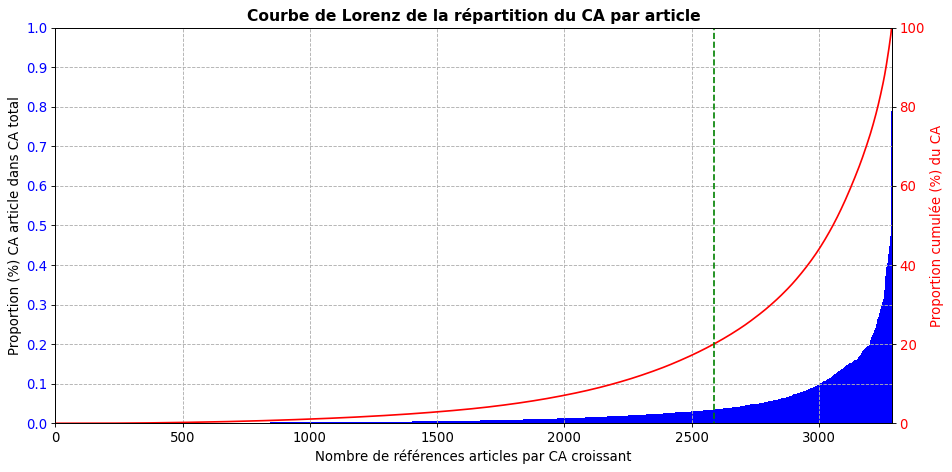


Coefficient de Gini pour la répartition du CA par article : 0.745 



In [56]:
##########################
# Courbe de Lorenz du CA #
##########################

#Créer une colonne calculant la part du CA de la ligne dans le dataset
df_CAprod["% CA"] = 100 * (df_CAprod["CA"] / CA_total)
df_CAprod.sort_values("% CA", ascending=True,inplace=True)

#Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_CAprod["CumSum % CA"] = (df_CAprod["% CA"]).cumsum()

#Calcul du 80/20
lim8020 = (df_CAprod.loc[df_CAprod["CumSum % CA"]>=20]).shape[0]
print("Nombre minimal d'articles les plus chers tous différents représentant 80% du CA :",lim8020)
print("Soit, en proportion du nombre d'articles de notre catalogue :", round(100 * lim8020 / (df_CAprod.shape[0]),1), "%\n")

#Courbe de Lorenz
df_CAprod.reset_index(inplace=True,drop=True)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=80)

p=ax1.bar(x=df_CAprod.index.values+0.5, height=df_CAprod['% CA'], width=1, color="blue")

ax1.set_xlabel("Nombre de références articles par CA croissant", fontsize=12)
ax1.set_xlim([0,df_CAprod.shape[0]+0.5])
ax1.set_ylabel("Proportion (%) CA article dans CA total", fontsize=12)
ax1.set_ylim([0,1])
ax1.set_yticks(np.linspace(0,1,11))
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
plt.grid(visible=True, axis='both', linestyle='--')

ax2 = ax1.twinx()  # crée un nouveau jeu d'axes avec le même axe x que ax1

ax2.plot(df_CAprod.index.values+0.5,df_CAprod['CumSum % CA'],color='red')

ax2.set_ylabel("Proportion cumulée (%) du CA", color='red', fontsize=12)
ax2.set_ylim([0,100])
ax2.set_yticks(np.linspace(0,100,6))
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
plt.title("Courbe de Lorenz de la répartition du CA par article", fontsize=14, fontweight='heavy')
fig.tight_layout() # Pour affichage optimal du 2nd axe vertical à droite

# Limite 80/20
plt.plot([df_CAprod.shape[0]-lim8020]*13, np.linspace(-10,110,13), color='green', linestyle='dashed')

plt.savefig("Lorenz_CA.png")
plt.show()

# Remarque : l'aire sous la courbe rouge (intégrale) est calculée par la méthode des rectangles
# Bien penser à normaliser en divisant par le nombre de références
print("\nCoefficient de Gini pour la répartition du CA par article :",round(1-0.02*(df_CAprod["CumSum % CA"]).sum()/(df_CAprod.shape[0]),3),"\n")

Nombre minimal d'articles les plus vendus tous différents représentant 80% des ventes : 810
Soit, en proportion du nombre d'articles de notre catalogue : 24.7 %



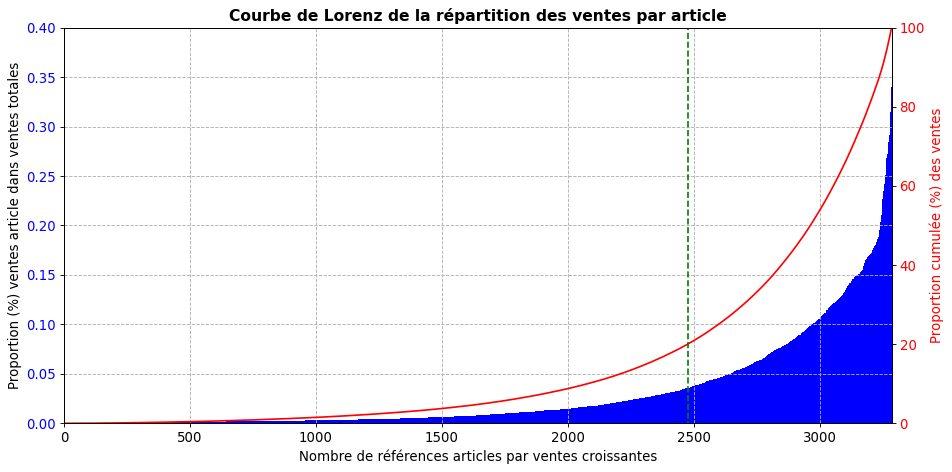


Coefficient de Gini pour la répartition des ventes par article : 0.697 



In [57]:
###############################
# Courbe de Lorenz des ventes #
###############################

#Créer une colonne calculant la part du CA de la ligne dans le dataset
df_CAprod["% qty"] = 100 * (df_CAprod["sales_qty"] / total_ventes)
df_CAprod.sort_values("% qty", ascending=True,inplace=True)

#Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_CAprod["CumSum % qty"] = (df_CAprod["% qty"]).cumsum()

#Calcul du 80/20
lim8020 = (df_CAprod.loc[df_CAprod["CumSum % qty"]>=20]).shape[0]
print("Nombre minimal d'articles les plus vendus tous différents représentant 80% des ventes :",lim8020)
print("Soit, en proportion du nombre d'articles de notre catalogue :", round(100 * lim8020 / (df_CAprod.shape[0]),1), "%\n")

#Courbe de Lorenz
df_CAprod.reset_index(inplace=True,drop=True)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=80)

p=ax1.bar(x=df_CAprod.index.values+0.5, height=df_CAprod['% qty'], width=1, color="blue")

ax1.set_xlabel("Nombre de références articles par ventes croissantes", fontsize=12)
ax1.set_xlim([0,df_CAprod.shape[0]+0.5])
ax1.set_ylabel("Proportion (%) ventes article dans ventes totales", fontsize=12)
ax1.set_ylim([0,0.4])
ax1.set_yticks(np.linspace(0,0.4,9))
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
plt.grid(visible=True, axis='both', linestyle='--')

ax2 = ax1.twinx()  # crée un nouveau jeu d'axes avec le même axe x que ax1

ax2.plot(df_CAprod.index.values+0.5,df_CAprod['CumSum % qty'],color='red')

ax2.set_ylabel("Proportion cumulée (%) des ventes", color='red', fontsize=12)
ax2.set_ylim([0,100])
ax2.set_yticks(np.linspace(0,100,6))
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
plt.title("Courbe de Lorenz de la répartition des ventes par article", fontsize=14, fontweight='heavy')
fig.tight_layout() # Pour affichage optimal du 2nd axe vertical à droite

# Limite 80/20
plt.plot([df_CAprod.shape[0]-lim8020]*13, np.linspace(-10,110,13), color='green', linestyle='dashed')

plt.savefig("Lorenz_Qty.png")
plt.show()

# Remarque : l'aire sous la courbe rouge (intégrale) est calculée par la méthode des rectangles
# Bien penser à normaliser en divisant par le nombre de références
print("\nCoefficient de Gini pour la répartition des ventes par article :",round(1-0.02*(df_CAprod["CumSum % qty"]).sum()/(df_CAprod.shape[0]),3),"\n")

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1.4 - Clients les plus importants en CA</h4>
</div>

In [58]:
df_CAclient = (df_CA.groupby('client_id')[["CA","sales_qty"]].sum()).reset_index().sort_values("CA",ascending=False)
display(df_CAclient)

,client_id,CA,sales_qty
677,c_1609,326039.89,25586
4388,c_4958,290227.03,5222
6337,c_6714,153918.60,9199
2724,c_3454,114110.57,6793
634,c_1570,5285.82,370
...,...,...,...
3855,c_4478,13.36,1
4044,c_4648,11.20,1
7889,c_8114,9.98,2
7918,c_8140,8.30,2


In [59]:
# Il convient d'ajouter à ce DataFrame les clients de notre base de données qui n'ont réalisé aucun achat sur la période
df_CAclient = df_clients.merge(df_CAclient,how='outer',left_on='client_id',right_on='client_id')
display(df_CAclient)

,client_id,sex,age,tranche,CA,sales_qty
0,c_1,M,68,52 et +,629.02,43.0
1,c_10,M,67,52 et +,1353.60,58.0
2,c_100,M,31,19-31,254.85,8.0
3,c_1000,F,57,52 et +,2291.88,126.0
4,c_1001,M,41,32-51,1823.85,103.0
...,...,...,...,...,...,...
8616,c_995,M,68,52 et +,189.41,14.0
8617,c_996,F,53,52 et +,1637.34,96.0
8618,c_997,F,29,19-31,1490.01,59.0
8619,c_998,M,22,19-31,2822.22,55.0


*NaN* dans la colonne *sex* (ou *age*) => Client qui a réalisé au moins un achat mais qui n'est pas enregistré => **Mettre à jour données clients**

*NaN* dans la colonne *CA* (ou *sales_qty*) => Client qui n'a pas réalisé d'achat => **Remplacer CA et sales_qty par 0**

In [60]:
print("Nombre de clients non-enregsitrés :", ((df_CAclient["client_id"]).isna()).sum())
print("Nombre de clients qui n'ont pas réalisé d'achat :", ((df_CAclient["CA"]).isna()).sum())

Nombre de clients non-enregsitrés : 0
Nombre de clients qui n'ont pas réalisé d'achat : 21


In [61]:
df_CAclient["CA"] = df_CAclient["CA"].fillna(0)
df_CAclient["sales_qty"] = df_CAclient["sales_qty"].fillna(0)
df_CAclient = df_CAclient.astype({"sales_qty": "int64"})
CA_total = df_CAclient["CA"].sum()
total_ventes = df_CAclient["sales_qty"].sum()
print("CA total sur l'ensemble de la période :",round(CA_total,2),"€")
print("Nombre total de produits vendus :",total_ventes)

CA total sur l'ensemble de la période : 12027663.1 €
Nombre total de produits vendus : 687534


In [62]:
############################
# Top 20 des clients en CA #
############################

#Effectuer le tri par ordre décroissant de CA
df_CAclient.sort_values("CA", ascending=False,inplace=True)
#Réinitialiser l'index du dataset par un reset_index
df_CAclient.reset_index(inplace=True,drop=True)
#Afficher les 20 premiers articles en CA
df_20CAclient = df_CAclient.head(20)
display(df_20CAclient)

,client_id,sex,age,tranche,CA,sales_qty
0,c_1609,M,43,32-51,326039.89,25586
1,c_4958,M,24,19-31,290227.03,5222
2,c_6714,F,55,52 et +,153918.60,9199
3,c_3454,M,54,52 et +,114110.57,6793
4,c_1570,F,44,32-51,5285.82,370
5,c_3263,F,38,32-51,5276.87,403
6,c_2140,F,46,32-51,5260.18,405
7,c_2899,F,29,19-31,5214.05,105
8,c_7319,F,49,32-51,5155.77,371
9,c_7959,F,49,32-51,5135.75,372


Les clients c_1609, c_4958, c_6714 et c_3454 se détachent des autres clients avec un chiffre d'affaires total au-delà de 100 k€.<br>
Examinons la distribution des CA par client.

Moyenne des CA par client : 1395.0
Premier quartile des CA : 559.44
Médiane des CA : 1044.58
Troisième quartile des CA : 1795.19

Nombre de clients avec un CA atypique (au moins 3648.82 €) : 252

Nombre de clients avec un CA très atypique (au moins 5502.45 €) : 4 



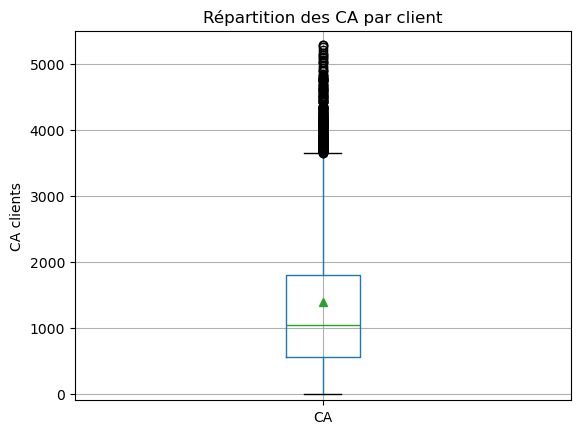

In [63]:
print("Moyenne des CA par client :",round(df_CAclient["CA"].mean(),0))

Q1 = round(df_CAclient["CA"].quantile(0.25),2)
Q3 = round(df_CAclient["CA"].quantile(0.75),2)

print("Premier quartile des CA :",Q1)
print("Médiane des CA :",round(df_CAclient["CA"].quantile(0.5),2))
print("Troisième quartile des CA :",Q3)

print("\nNombre de clients avec un CA atypique (au moins",\
      round(0.01+Q3+1.5*(Q3-Q1),2),"€) :",\
      df_CAclient.loc[df_CAclient["CA"]>=Q3+1.5*(Q3-Q1)].shape[0])

print("\nNombre de clients avec un CA très atypique (au moins",\
      round(0.01+Q3+3*(Q3-Q1),2),"€) :",\
      df_CAclient.loc[df_CAclient["CA"]>=Q3+3*(Q3-Q1)].shape[0],"\n")

df_CAclient.boxplot(column=["CA"],showmeans=True)
plt.ylabel("CA clients")
plt.ylim([-100,5500])
plt.title("Répartition des CA par client")
plt.show()

On considère donc que nos clients ayant un CA supérieur à 100 k€ sont des clients BtoB.

La distribution des CA ne suit manifestement pas une loi normale. Vérifions cela avec le test de Shapiro-Wilk.<br>
Hypothèses :
- (H0) : les données suivent une distribution normale
- (H1) : les données ne suivent pas une distribution normale

In [64]:
# On enlève les clients BtoB (CA > 100000 €)
data = df_CAclient.loc[df_CAclient['CA']<1e5]['CA']

# Estimer la moyenne et l'écart type
mean_CA = data.mean()
std_CA = data.std(ddof=1)    # Estimateur sans biais

# Afficher les valeurs calculées
print(f"CA moyen par client : {round(mean_CA,2)}")
print(f"Écart type des CA client : {round(std_CA,2)}")

# Test de Shapiro-Wilk
stat, p_value = st.shapiro(data)

# Afficher les résultats
print(f"Statistique du test de Shapiro-Wilk : {stat}")
print(f"Valeur p : {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (on ne rejette pas H0)")
else:
    print("Les données ne suivent pas une distribution normale (on rejette H0)")

CA moyen par client : 1293.18
Écart type des CA client : 959.37
Statistique du test de Shapiro-Wilk : 0.9050666243558595
Valeur p : 1.8901274292474976e-58
Les données ne suivent pas une distribution normale (on rejette H0)


C:\Users\nicol\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8617.
  res = hypotest_fun_out(*samples, **kwds)


In [65]:
df_clientB2B = df_CAclient.loc[df_CAclient["CA"]>=1e5]
display(df_clientB2B)
l_clientB2B = list(df_clientB2B["client_id"])
print("Les clients BtoB représentent",round(100*df_clientB2B["CA"].sum()/CA_total,1),"% du CA total sur l'ensemble de la période.")

,client_id,sex,age,tranche,CA,sales_qty
0,c_1609,M,43,32-51,326039.89,25586
1,c_4958,M,24,19-31,290227.03,5222
2,c_6714,F,55,52 et +,153918.60,9199
3,c_3454,M,54,52 et +,114110.57,6793


Les clients BtoB représentent 7.4 % du CA total sur l'ensemble de la période.


In [66]:
# Données clients sans clients BtoB
df_clients_corr = df_clients.loc[~df_clients["client_id"].isin(l_clientB2B)]

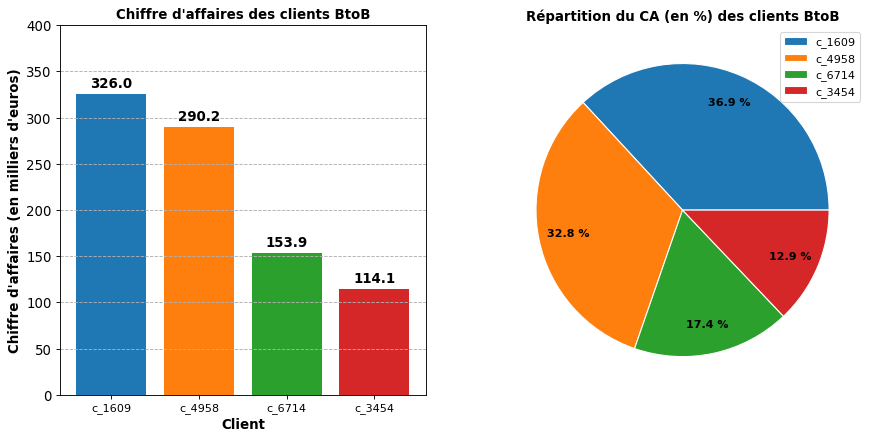

In [67]:
#Affichage graphique CA des clients BtoB
fig = plt.figure(figsize=(13,6), dpi=80)

plt.subplot(1,2,1)
p=plt.bar(df_clientB2B["client_id"], df_clientB2B['CA']/1e3, color=[cm['tab10'](i) for i in range(len(df_clientB2B))])
plt.bar_label(p, label_type='edge', fmt='%.1f', padding=3.0, fontsize=12, fontweight='bold')
plt.xlabel("Client", fontsize=12, fontweight='heavy')
plt.ylabel("Chiffre d'affaires (en milliers d'euros)", fontsize=12, fontweight='heavy')
plt.ylim([0,400])
plt.title("Chiffre d'affaires des clients BtoB", fontsize=12, fontweight='heavy')
plt.yticks(np.linspace(0,400,9),fontsize=12)
plt.grid(visible=True, axis='y', linestyle='--')

plt.subplot(1,2,2)
plt.pie(df_clientB2B["CA"],\
        pctdistance=0.8,\
        wedgeprops={'edgecolor': 'w'},\
        autopct=lambda x: f"{x:.1f} %",\
        textprops={'fontweight': 'bold'})
plt.legend(list(df_clientB2B["client_id"]), loc='best')
plt.title("Répartition du CA (en %) des clients BtoB", fontsize=12, fontweight='heavy')
plt.savefig("CA_B2B.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1.5 - CA par client : courbe de Lorenz</h4>
</div>

Nombre minimal de clients tous différents représentant 80% du CA : 4330
Soit, en proportion du nombre de clients de notre portefeuille : 50.2 %



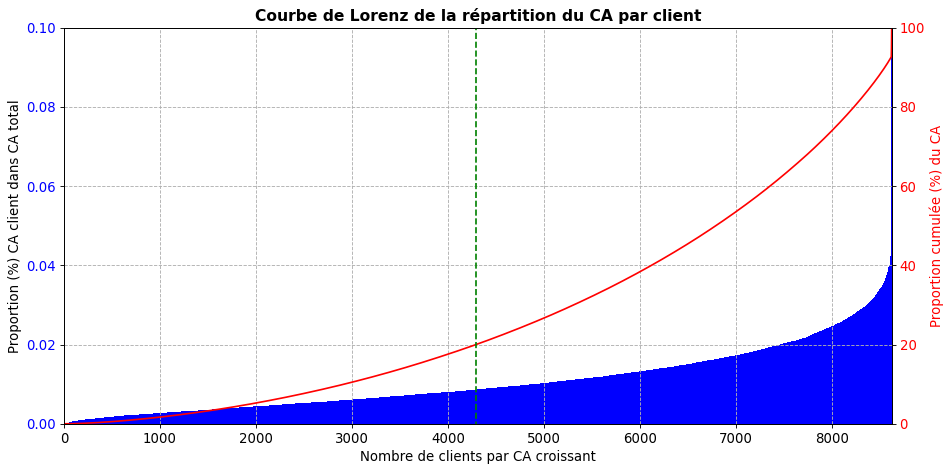


Coefficient de Gini pour la répartition du CA par client : 0.443 



In [68]:
#####################################
# Courbe de Lorenz du CA par client #
#####################################

#Créer une colonne calculant la part du CA de la ligne dans le dataset
df_CAclient["% CA"] = 100 * (df_CAclient["CA"] / CA_total)
df_CAclient.sort_values("% CA", ascending=True,inplace=True)

#Créer une colonne réalisant la somme cumulative de la colonne précedemment créée
df_CAclient["CumSum % CA"] = (df_CAclient["% CA"]).cumsum()

#Calcul du 80/20
lim8020 = (df_CAclient.loc[df_CAclient["CumSum % CA"]>=20]).shape[0]
print("Nombre minimal de clients tous différents représentant 80% du CA :",lim8020)
print("Soit, en proportion du nombre de clients de notre portefeuille :", round(100 * lim8020 / (df_CAclient.shape[0]),1), "%\n")

#Courbe de Lorenz
df_CAclient.reset_index(inplace=True,drop=True)

fig, ax1 = plt.subplots(figsize=(12,6), dpi=80)

p=ax1.bar(x=df_CAclient.index.values+0.5, height=df_CAclient['% CA'], width=1, color="blue")

ax1.set_xlabel("Nombre de clients par CA croissant", fontsize=12)
ax1.set_xlim([0,df_CAclient.shape[0]+0.5])
ax1.set_ylabel("Proportion (%) CA client dans CA total", fontsize=12)
ax1.set_ylim([0,0.1])
ax1.set_yticks(np.linspace(0,0.1,6))
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
plt.grid(visible=True, axis='both', linestyle='--')

ax2 = ax1.twinx()  # crée un nouveau jeu d'axes avec le même axe x que ax1

ax2.plot(df_CAclient.index.values+0.5,df_CAclient['CumSum % CA'],color='red')

ax2.set_ylabel("Proportion cumulée (%) du CA", color='red', fontsize=12)
ax2.set_ylim([0,100])
ax2.set_yticks(np.linspace(0,100,6))
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
plt.title("Courbe de Lorenz de la répartition du CA par client", fontsize=14, fontweight='heavy')
fig.tight_layout() # Pour affichage optimal du 2nd axe vertical à droite

# Limite 80/20
plt.plot([df_CAclient.shape[0]-lim8020]*13, np.linspace(-10,110,13), color='green', linestyle='dashed')

plt.savefig("Lorenz_CAclient.png")
plt.show()

# Remarque : l'aire sous la courbe rouge (intégrale) est calculée par la méthode des rectangles
# Bien penser à normaliser en divisant par le nombre de références
print("\nCoefficient de Gini pour la répartition du CA par client :",\
      round(1-0.02*(df_CAclient["CumSum % CA"]).sum()/(df_CAclient.shape[0]),3),"\n")

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.1.6 - CA par tranche d'âges</h4>
</div>

,CA
tranche,
19-31,3334899.37
32-51,5613811.42
52 et +,3078952.31


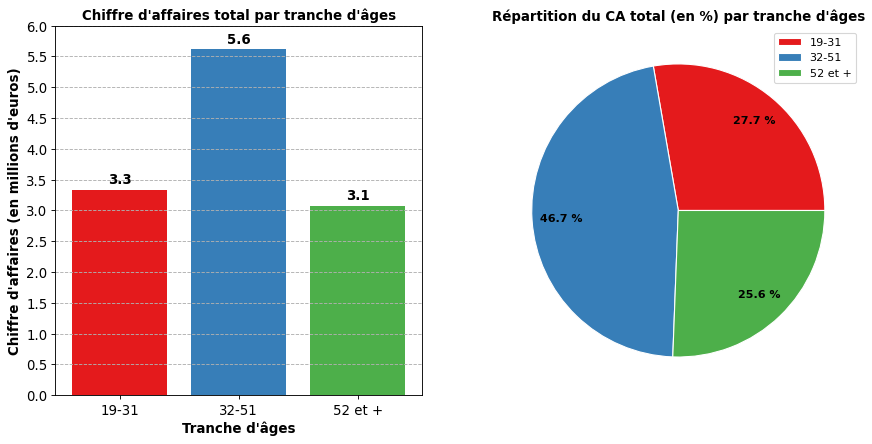

In [69]:
df_CATranche = (df_CAclient.groupby('tranche')[["CA"]].sum()).sort_values("tranche",ascending=True)

display(df_CATranche)

#Affichage graphique : diagramme en secteurs
fig = plt.figure(figsize=(13,6), dpi=80)

plt.subplot(1,2,1)
p=plt.bar(df_CATranche.index, df_CATranche['CA']/1e6,\
          color=[cm['Set1'](i) for i in np.arange(len(list(df_CATranche.index)))])
plt.bar_label(p, label_type='edge', fmt='%.1f', padding=3.0, fontsize=12, fontweight='bold')
plt.xlabel("Tranche d'âges", fontsize=12, fontweight='heavy')
plt.ylabel("Chiffre d'affaires (en millions d'euros)", fontsize=12, fontweight='heavy')
plt.ylim([0,6])
plt.title("Chiffre d'affaires total par tranche d'âges", fontsize=12, fontweight='heavy')
plt.xticks(np.linspace(0,2,3),fontsize=12)
plt.yticks(np.linspace(0,6.0,13),fontsize=12)
plt.grid(visible=True, axis='y', linestyle='--')

plt.subplot(1,2,2)
plt.pie(df_CATranche["CA"],\
        colors=[cm['Set1'](i) for i in np.arange(len(list(df_CATranche.index)))],\
        pctdistance=0.8,\
        wedgeprops={'edgecolor': 'w'},\
        autopct=lambda x: f"{x:.1f} %",\
        textprops={'fontweight': 'bold'})
plt.legend(list(df_CATranche.index), loc='best')
plt.title("Répartition du CA total (en %) par tranche d'âges", fontsize=12, fontweight='heavy')
plt.savefig("Rep_CA_tranche.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2 - Analyses temporelles</h3>
</div>

On repart des données de transaction. Il nous faut d'abord convertir la colonne date, jusque-là de type *string*, en type *date*.

In [70]:
# Il faut récupérer les données de prix : on effectue une jointure sur les données produits
df_achats = df_ventes.merge(df_products,how='left',left_on='id_prod',right_on='id_prod')

df_achats_mois = df_achats.copy()

df_achats_mois['date'] = df_achats_mois['date'].apply(lambda s: s[0:7])

df_achats["date"] = pd.to_datetime(df_achats['date'], format='%Y-%m-%d', dayfirst=True)
df_achats_mois['date'] = pd.to_datetime(df_achats_mois['date'], format='%Y-%m', dayfirst=True)
#Remarque : comme chaque ligne correspond à un seul produit, le prix et le CA sont confondus
df_achats.rename(columns={"price": "CA"}, inplace=True)
df_achats_mois.rename(columns={"price": "CA"}, inplace=True)

# Trier les données par date
df_achats = df_achats.sort_values('date')
df_achats_mois = df_achats_mois.sort_values('date')
display(df_achats)
df_achats.dtypes

,id_prod,date,session_id,client_id,CA,categ
0,0_1259,2021-03-01,s_1,c_329,11.99,0
634,0_1481,2021-03-01,s_303,c_3745,3.99,0
635,2_37,2021-03-01,s_289,c_4958,48.99,2
636,0_1421,2021-03-01,s_317,c_8024,19.99,0
637,0_1471,2021-03-01,s_310,c_6714,12.99,0
...,...,...,...,...,...,...
686898,1_170,2023-02-28,s_348127,c_1344,14.22,1
686899,0_1324,2023-02-28,s_348109,c_6538,3.93,0
686900,0_2207,2023-02-28,s_348108,c_1609,7.99,0
686812,1_462,2023-02-28,s_348086,c_8523,16.66,1


id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
CA                   float64
categ                  int64
dtype: object

In [71]:
display(df_achats_mois)

,id_prod,date,session_id,client_id,CA,categ
0,0_1259,2021-03-01,s_1,c_329,11.99,0
19073,1_444,2021-03-01,s_9448,c_5918,12.61,1
19072,0_1378,2021-03-01,s_9451,c_4951,13.96,0
19071,2_60,2021-03-01,s_9458,c_6275,111.72,2
19070,0_1895,2021-03-01,s_9453,c_6251,3.99,0
...,...,...,...,...,...,...
670499,0_1641,2023-02-01,s_339652,c_7211,14.99,0
670498,1_267,2023-02-01,s_339660,c_6652,27.99,1
670497,0_1519,2023-02-01,s_339651,c_8200,5.99,0
670495,1_475,2023-02-01,s_339658,c_4401,20.99,1


<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2.1 - Chiffre d'affaires total avec moyenne mobile</h4>
</div>

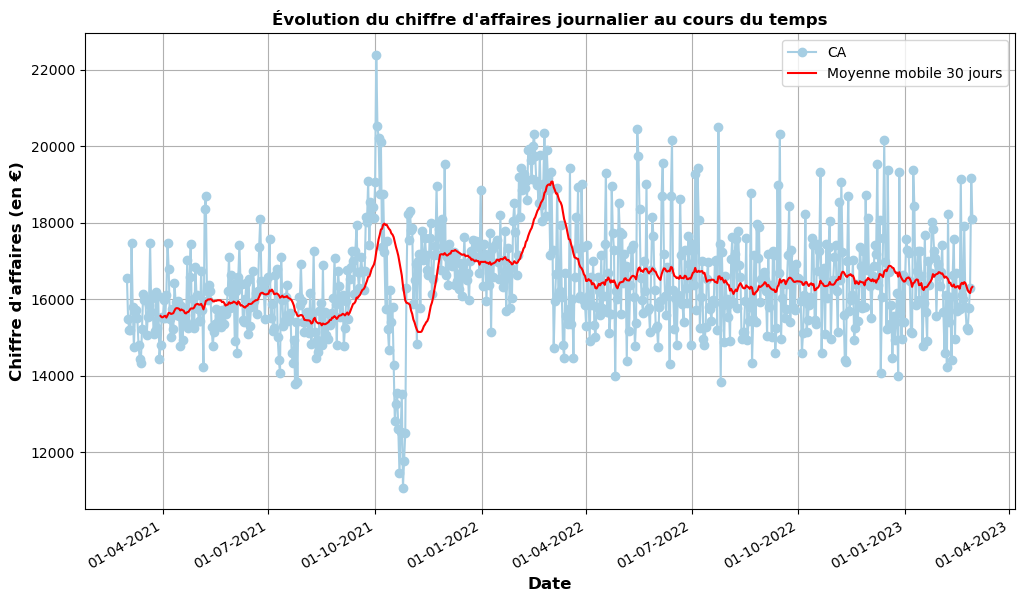

In [72]:
df_achats_jour = (df_achats.groupby("date")["CA"].sum()).reset_index().sort_values("date")

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

plt.plot(df_achats_jour['date'], df_achats_jour['CA'], marker="o", linestyle='-', color=cm['Paired'](0), label="CA")
plt.plot(df_achats_jour['date'], df_achats_jour['CA'].rolling(30).mean(), linestyle='-', color='red', label="Moyenne mobile 30 jours")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution du chiffre d'affaires journalier au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Date', fontsize=12, fontweight='heavy')
plt.ylabel("Chiffre d'affaires (en €)", fontsize=12, fontweight='heavy')
plt.grid(True)
plt.savefig("CA_Temps.png")
plt.show()

In [73]:
display(df_ventes)

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01,s_1,c_329
1,0_1390,2021-03-01,s_2,c_664
2,0_1352,2021-03-01,s_3,c_580
3,0_1458,2021-03-01,s_4,c_7912
4,0_1358,2021-03-01,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-28,s_348444,c_3573
687530,2_37,2023-02-28,s_348445,c_50
687531,1_695,2023-02-28,s_348446,c_488
687532,0_1547,2023-02-28,s_348447,c_4848


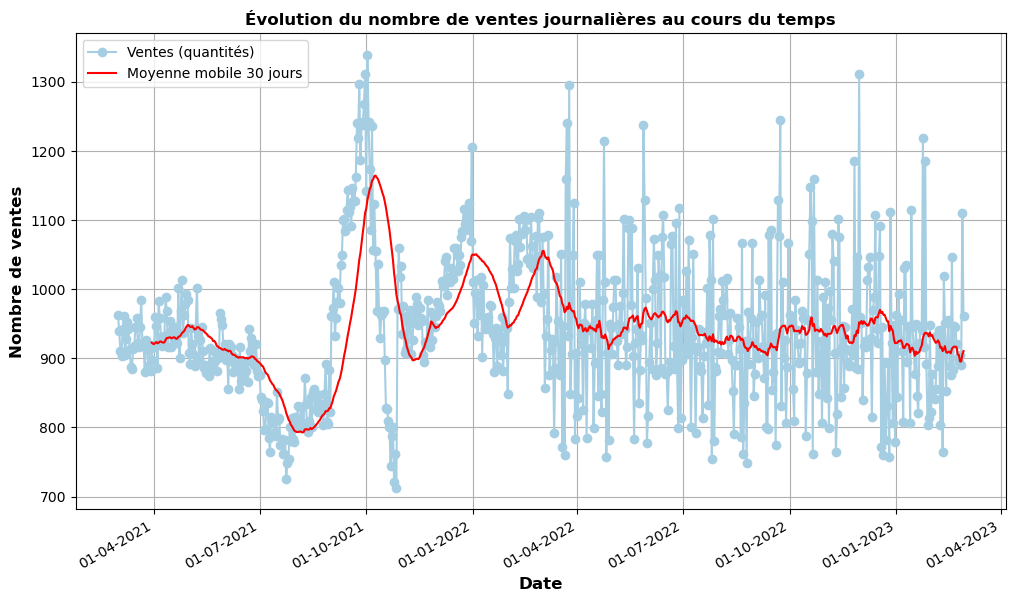

In [74]:
df_nb_achats_jour = (df_achats.groupby("date").count()).reset_index().sort_values("date")

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

plt.plot(df_nb_achats_jour['date'], df_nb_achats_jour['id_prod'], marker="o", linestyle='-', color=cm['Paired'](0), label="Ventes (quantités)")
plt.plot(df_nb_achats_jour['date'], df_nb_achats_jour['id_prod'].rolling(30).mean(), linestyle='-', color='red', label="Moyenne mobile 30 jours")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution du nombre de ventes journalières au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Date', fontsize=12, fontweight='heavy')
plt.ylabel("Nombre de ventes", fontsize=12, fontweight='heavy')
plt.grid(True)
plt.savefig("Sales_Qty_Temps.png")
plt.show()

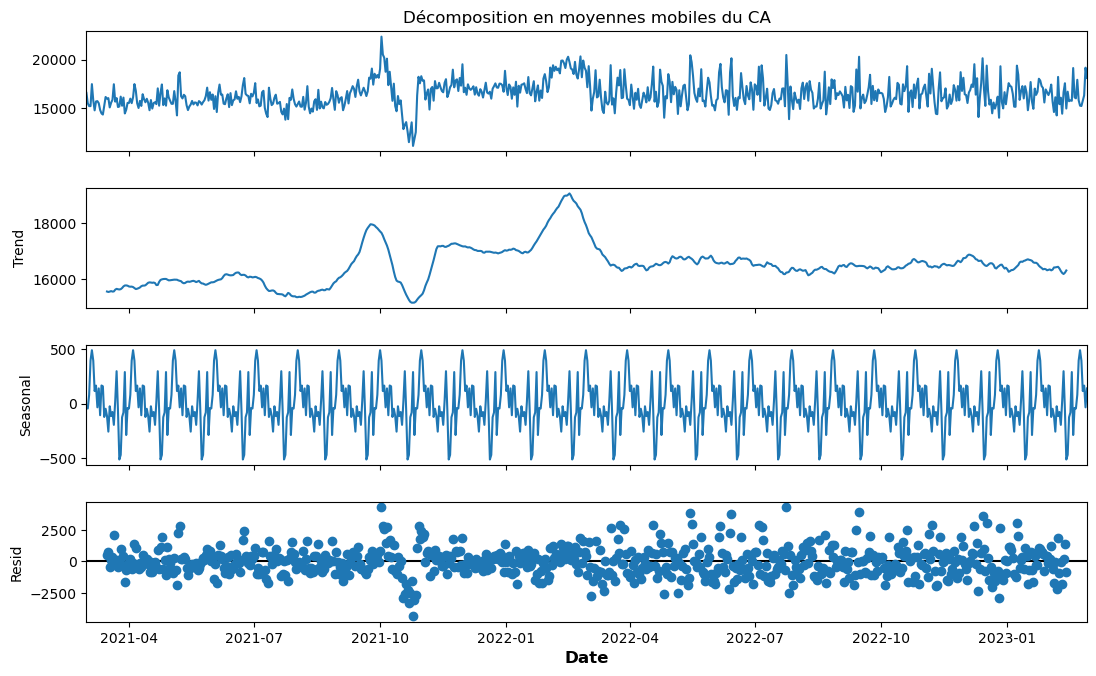

In [75]:
# Décomposition en moyennes mobiles de la série temporelle du CA

y = (df_achats.groupby("date")["CA"].sum())

y.rename("Décomposition en moyennes mobiles du CA", inplace=True)

decomp = seasonal_decompose(y, model='additive', period=30)

fig = decomp.plot()
fig.set_size_inches((12, 7))

plt.xlabel('Date', fontsize=12, fontweight='heavy')
plt.savefig("CA_Decomp.png")
plt.show()


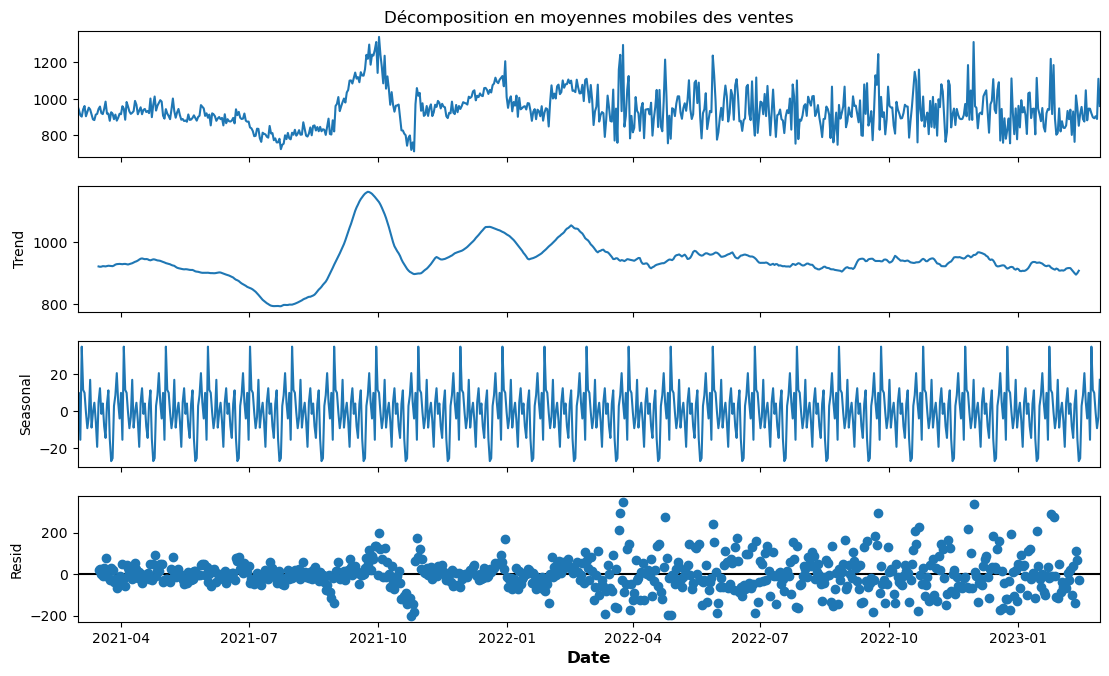

In [76]:
# Décomposition en moyennes mobiles de la série temporelle des ventes

y = df_achats.groupby("date")["id_prod"].count()

y.rename("Décomposition en moyennes mobiles des ventes", inplace=True)

decomp = seasonal_decompose(y, model='additive', period=30)

fig = decomp.plot()
fig.set_size_inches((12, 7))

plt.xlabel('Date', fontsize=12, fontweight='heavy')
plt.savefig("Ventes_Decomp.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2.2 - Chiffre d'affaires par catégorie</h4>
</div>

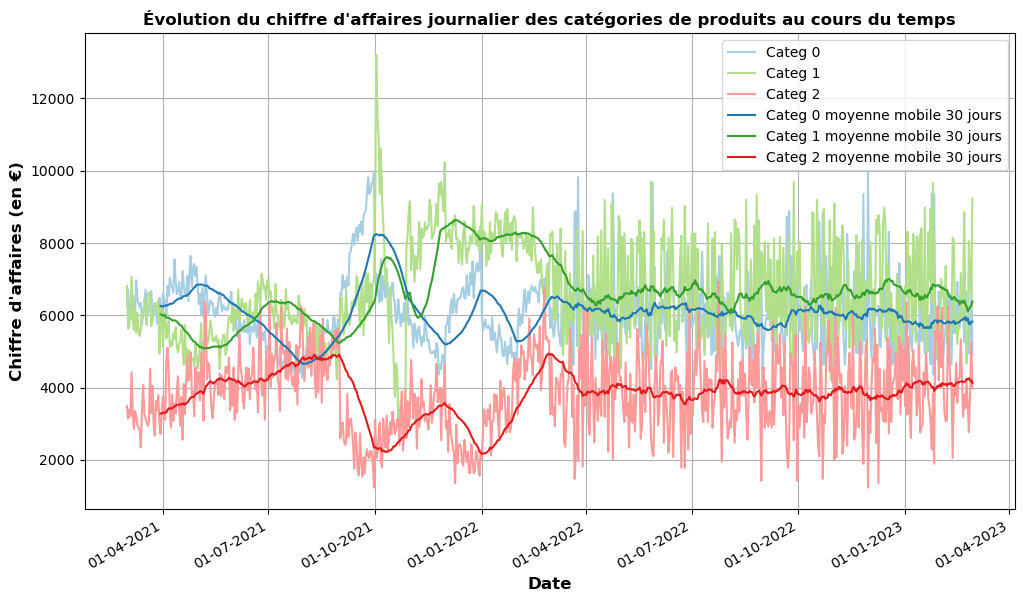

In [77]:
df_achats_jour_cat = pd.pivot_table(df_achats, values='CA', index=['date'], columns=['categ'], aggfunc="sum")
df_achats_jour_cat = df_achats_jour_cat.reset_index().sort_values("date")
df_achats_jour_cat.rename(columns={i: "categ "+str(i) for i in list(df_products["categ"].unique())}, inplace=True)

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

for i in list(df_products["categ"].unique()):
    plt.plot(df_achats_jour_cat['date'], df_achats_jour_cat["categ "+str(i)],\
             linestyle='-', color=cm['Paired'](2*i), label="Categ "+str(i))

for i in list(df_products["categ"].unique()):
    plt.plot(df_achats_jour_cat['date'], df_achats_jour_cat["categ "+str(i)].rolling(30).mean(),\
             linestyle='-', color=cm['Paired'](2*i+1), label="Categ "+str(i)+" moyenne mobile 30 jours")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution du chiffre d'affaires journalier des catégories de produits au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Date', fontsize=12, fontweight='heavy')
plt.ylabel("Chiffre d'affaires (en €)", fontsize=12, fontweight='heavy')
plt.grid(True)
plt.savefig("CA_Temps_catégorie.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2.3 - Nombre de clients par mois</h4>
</div>

In [78]:
df_ventes_mois = df_ventes.copy()
# On regroupe les données par mois, au premier jour de chaque mois
df_ventes_mois["date"] = (df_ventes_mois["date"]).apply(lambda s: s[0:7])
df_ventes_mois["date"] = pd.to_datetime(df_ventes_mois['date'], format='%Y-%m')
display(df_ventes_mois)
df_ventes_mois.dtypes

,id_prod,date,session_id,client_id
0,0_1259,2021-03-01,s_1,c_329
1,0_1390,2021-03-01,s_2,c_664
2,0_1352,2021-03-01,s_3,c_580
3,0_1458,2021-03-01,s_4,c_7912
4,0_1358,2021-03-01,s_5,c_2033
...,...,...,...,...
687529,1_508,2023-02-01,s_348444,c_3573
687530,2_37,2023-02-01,s_348445,c_50
687531,1_695,2023-02-01,s_348446,c_488
687532,0_1547,2023-02-01,s_348447,c_4848


id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

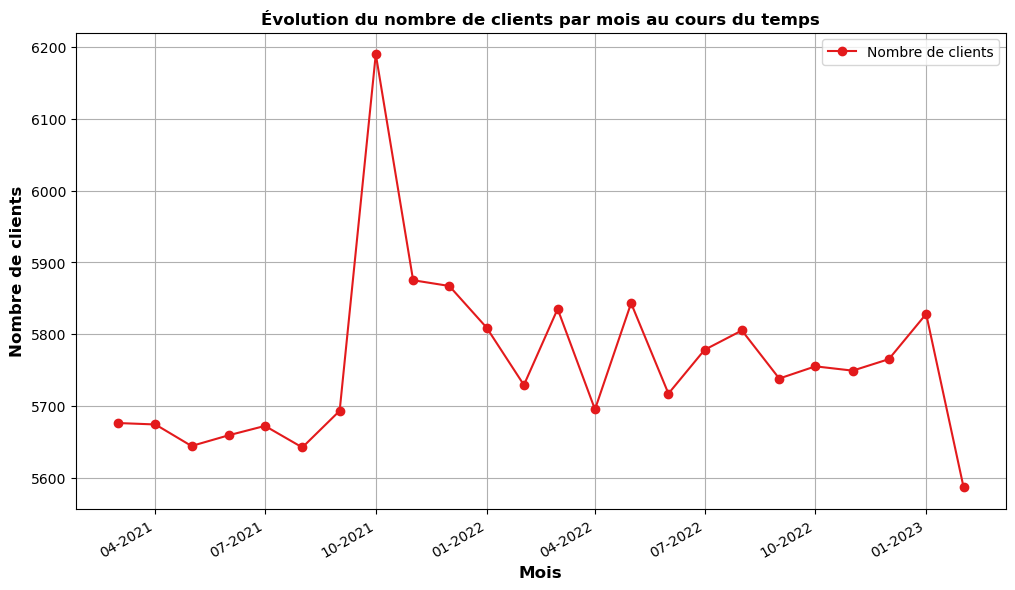

In [79]:
# On prend en compte les clients distincts
df_clients_mois = (df_ventes_mois.groupby("date")["client_id"].nunique()).reset_index().sort_values("date")
df_clients_mois.rename(columns={"client_id": "nb_clients"}, inplace=True)

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

plt.plot(df_clients_mois['date'], df_clients_mois["nb_clients"],marker='o',\
         linestyle='-', color=cm['Paired'](5), label="Nombre de clients")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution du nombre de clients par mois au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Mois', fontsize=12, fontweight='heavy')
plt.ylabel("Nombre de clients", fontsize=12, fontweight='heavy')
plt.grid(True)
plt.savefig("Clients_mois.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2.4 - Nombre de sessions d'achat par mois</h4>
</div>

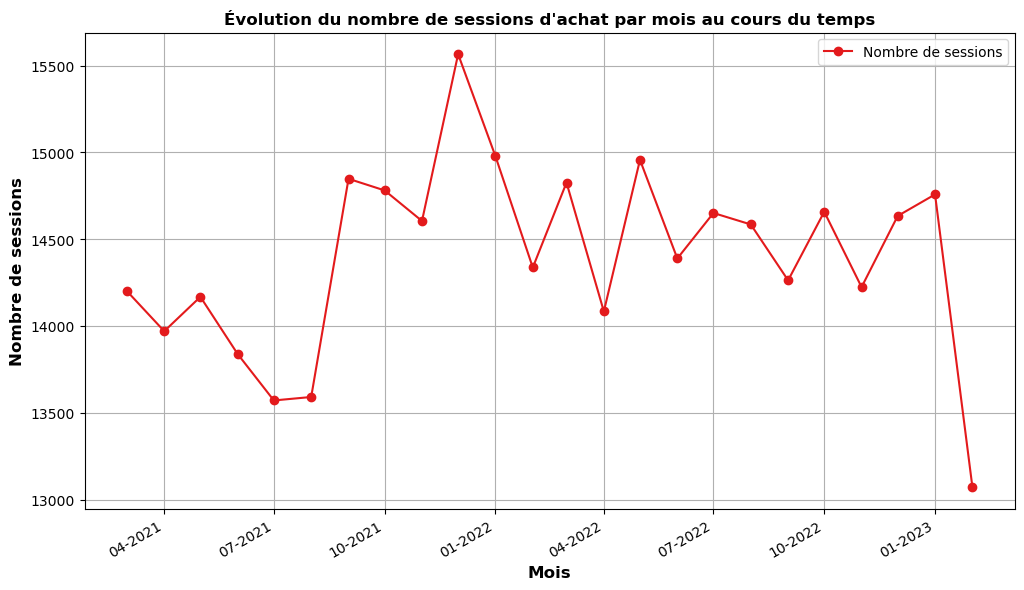

In [80]:
# On prend en compte les sessions d'achat distinctes
df_clients_mois = (df_ventes_mois.groupby("date")["session_id"].nunique()).reset_index().sort_values("date")
df_clients_mois.rename(columns={"session_id": "nb_sessions"}, inplace=True)

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

plt.plot(df_clients_mois['date'], df_clients_mois["nb_sessions"],marker='o',\
         linestyle='-', color=cm['Paired'](5), label="Nombre de sessions")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution du nombre de sessions d'achat par mois au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Mois', fontsize=12, fontweight='heavy')
plt.ylabel("Nombre de sessions", fontsize=12, fontweight='heavy')
plt.grid(True)
plt.savefig("Sessions_mois.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2.5 - Nombre de produits vendus par mois</h4>
</div>

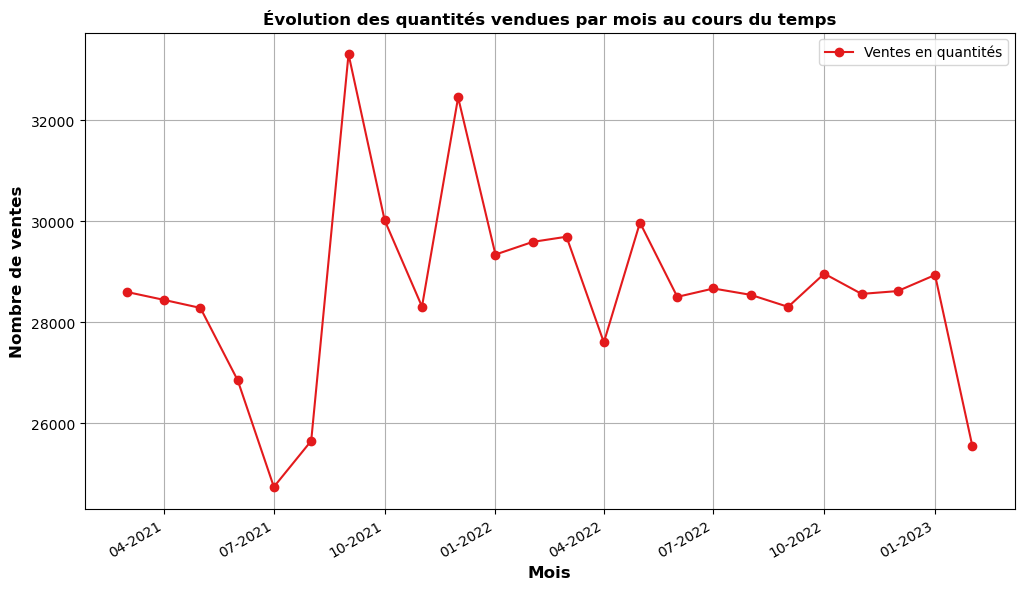

In [81]:
# On prend en compte le nombre total de produits sans distinction
df_clients_mois = (df_ventes_mois.groupby("date")["id_prod"].count()).reset_index().sort_values("date")
df_clients_mois.rename(columns={"id_prod": "nb_sales"}, inplace=True)

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

plt.plot(df_clients_mois['date'], df_clients_mois["nb_sales"],marker='o',\
         linestyle='-', color=cm['Paired'](5), label="Ventes en quantités")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution des quantités vendues par mois au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Mois', fontsize=12, fontweight='heavy')
plt.ylabel("Nombre de ventes", fontsize=12, fontweight='heavy')
plt.grid(True)
plt.savefig("Ventes_mois.png")
plt.show()

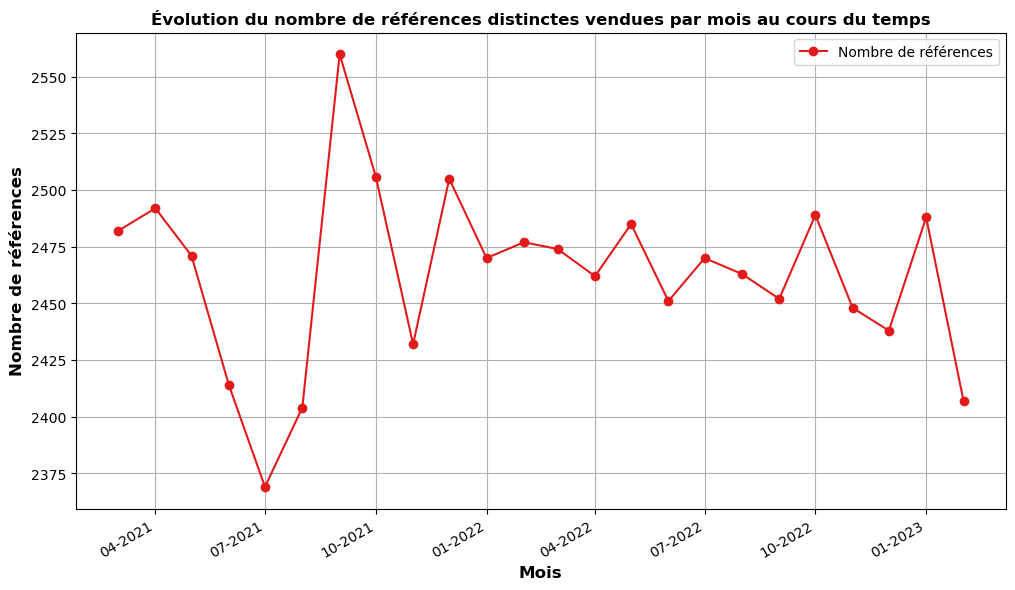

In [82]:
# On prend en compte le nombre de produits distincts
df_clients_mois = (df_ventes_mois.groupby("date")["id_prod"].nunique()).reset_index().sort_values("date")
df_clients_mois.rename(columns={"id_prod": "nb_ref"}, inplace=True)

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

plt.plot(df_clients_mois['date'], df_clients_mois["nb_ref"],marker='o',\
         linestyle='-', color=cm['Paired'](5), label="Nombre de références")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution du nombre de références distinctes vendues par mois au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Mois', fontsize=12, fontweight='heavy')
plt.ylabel("Nombre de références", fontsize=12, fontweight='heavy')
plt.grid(True)
plt.savefig("Références_mois.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h4 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">3.2.6 - CA par mois</h4>
</div>

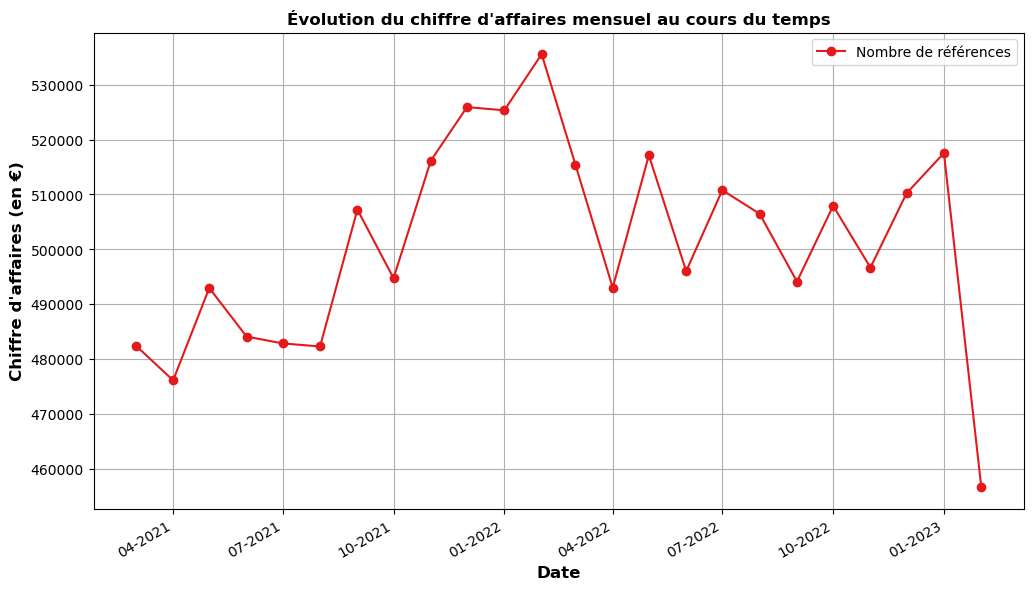

In [83]:
df_achats_mois = (df_achats_mois.groupby("date")["CA"].sum()).reset_index().sort_values("date")

# Création du graphique en ligne
plt.figure(figsize=(12, 7))

plt.plot(df_achats_mois['date'], df_achats_mois["CA"],marker='o',\
         linestyle='-', color=cm['Paired'](5), label="Nombre de références")

# Formater l'axe des X pour afficher les dates correctement
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotation automatique des dates pour une meilleure lisibilité

plt.legend()

plt.title("Évolution du chiffre d'affaires mensuel au cours du temps", fontsize=12, fontweight='heavy')
plt.xlabel('Date', fontsize=12, fontweight='heavy')
plt.ylabel("Chiffre d'affaires (en €)", fontsize=12, fontweight='heavy')
plt.grid(True)
#plt.savefig("CA_Temps.png")
plt.show()

<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 4 - Étude des corrélations : comportements des clients</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.1 - Genre des clients et catégories de produits achetés</h3>
</div>

On s'intéresse au nombre (entier) de produits de chaque catégorie achetés par un client.

In [84]:
# 1 observation = 1 transaction (1 produit & 1 client)

# Nombre de produits
datanb = df_clients_corr.merge(df_achats, how='inner',left_on='client_id',right_on='client_id')
display(datanb)
contingency_table = pd.crosstab(datanb['sex'], datanb['categ'])

# Calculer le test du Chi-2
# Hypothèse H0 : il y a indépendance entre catégorie de produits acheté et sexe
chi2_stat, p_value, dof, expected = st.chi2_contingency(contingency_table)

print(f"Statistique Chi-2: {chi2_stat}")
print(f"Valeur p: {p_value}")
print(f"Degrés de liberté: {dof}")
print("\nFréquences attendues:")
print(expected)
print("")
print(contingency_table)

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("\nLes variables sont indépendantes (on ne rejette pas H0)")
else:
    print("\nLes variables ne sont pas indépendantes (on rejette H0)")

,client_id,sex,age,tranche,id_prod,date,session_id,CA,categ
0,c_4410,F,56,52 et +,1_483,2021-03-13,s_5913,15.99,1
1,c_4410,F,56,52 et +,0_1455,2021-03-22,s_9942,8.99,0
2,c_4410,F,56,52 et +,0_1420,2021-03-22,s_10092,11.53,0
3,c_4410,F,56,52 et +,0_1111,2021-03-22,s_9707,19.99,0
4,c_4410,F,56,52 et +,1_385,2021-03-22,s_9707,25.99,1
...,...,...,...,...,...,...,...,...,...
640729,c_84,F,41,32-51,0_1472,2022-05-14,s_208110,12.49,0
640730,c_84,F,41,32-51,0_1438,2022-05-29,s_215697,9.31,0
640731,c_84,F,41,32-51,1_688,2022-12-17,s_313173,18.19,1
640732,c_84,F,41,32-51,1_459,2022-12-17,s_313173,15.99,1


Statistique Chi-2: 22.66856665178056
Valeur p: 1.1955928116587024e-05
Degrés de liberté: 2

Fréquences attendues:
[[201574.89662481 114822.13191434  17096.97146086]
 [185706.10337519 105782.86808566  15751.02853914]]

categ       0       1      2
sex                         
F      200793  115721  16980
M      186488  104884  15868

Les variables ne sont pas indépendantes (on rejette H0)


Il semble que les hommes achètent plus de produits de la catégorie 0 qu'ils ne le devraient (si H0 était vraie) tandis que les femmes achètent plus de produits de la catégorie 1 qu'elles ne le devraient (si H0 était vraie).

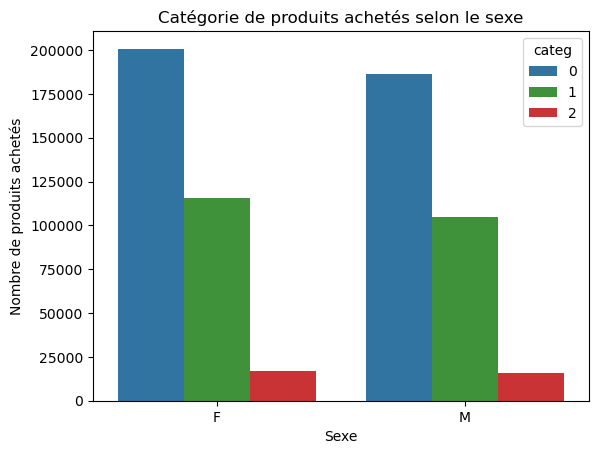

In [85]:
datanb['nombre']=1
sb.barplot(data=datanb,
           x="sex", y="nombre", hue="categ", estimator='sum',\
           palette=[cm['Paired'](2*i+1) for i in list(df_products["categ"].unique())])
plt.xlabel("Sexe")
plt.ylabel("Nombre de produits achetés")
plt.title("Catégorie de produits achetés selon le sexe")
plt.savefig("Categ_sex.png")
plt.show()

<Axes: xlabel='categ', ylabel='sex'>

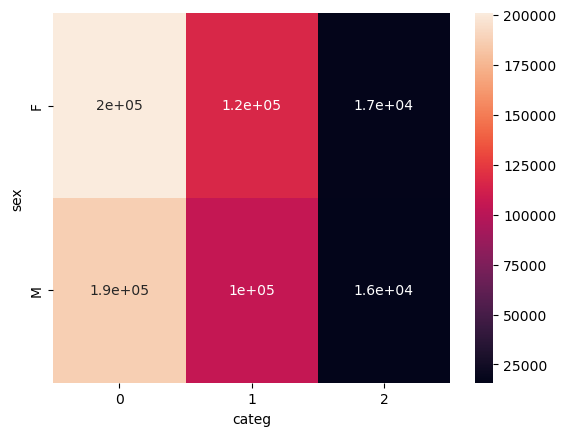

In [86]:
sb.heatmap(contingency_table, annot=True)

In [87]:
table = contingency_table
total = pd.DataFrame([{i: table[i].sum() for i in list(df_products["categ"].unique())}],index=["Total"])
table = pd.concat([table,total],axis=0)
table["total"] = table.sum(axis=1)
for i in list(df_products["categ"].unique()):
    table[i] = 100*table[i]/table["total"]
table.drop(["total"],axis=1, inplace=True)
display(table)


,0,1,2
F,60.208879,34.699575,5.091546
M,60.697826,34.137482,5.164692
Total,60.443335,34.430044,5.126620


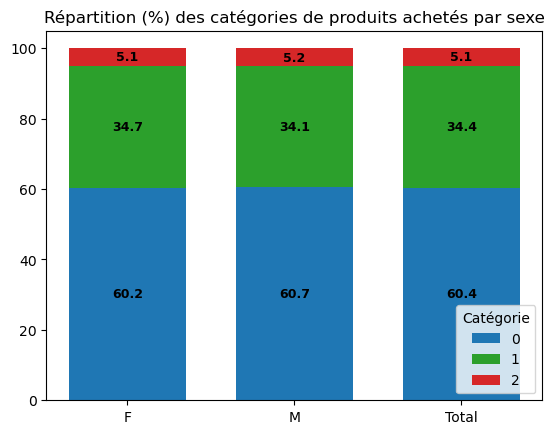

In [88]:
# Graphique en barres empilées 100%

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, x in table.items():
    p = ax.bar(list(table.index), x, width=0.7, label=boolean, bottom=bottom,\
               color=df_couleurs.loc[df_couleurs['categ']==(x.name)]["couleur"])
    plt.bar_label(p, label_type='center', fmt='%.1f', fontsize=9, fontweight='bold')
    bottom += x

ax.set_title("Répartition (%) des catégories de produits achetés par sexe")
ax.legend(title="Catégorie",loc="lower right")
plt.ylim([0,105])
plt.yticks(np.linspace(0,100,6))

plt.savefig("Categ_sex_stacked.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.2 - Âge des clients et montant total des achats</h3>
</div>

On a vu précédemment qu'aucune de ces 2 variables ne suivaient pas une loi normale. On va donc utiliser le test de corrélation de Spearman.<br>
Hypothèse (H0) : les 2 variables ne sont pas corrélées.

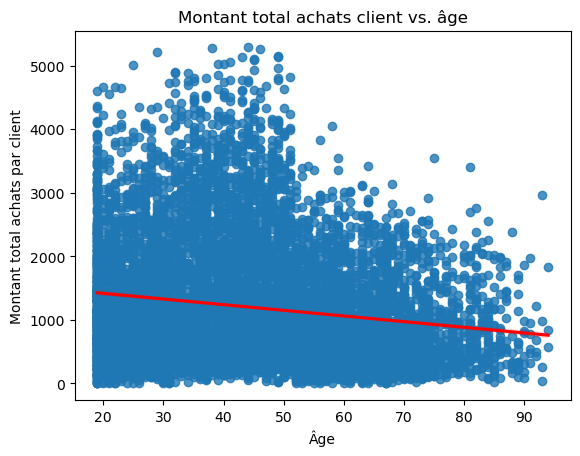

Coefficient de corrélation de Spearman : -0.181853352233868
Valeur p : 5.767510377052537e-65

Les variables sont corrélées (on rejette H0)


In [89]:
# 1 observation = 1 client

data = df_CAclient.loc[df_CAclient['CA']<1e5][["age","CA"]]

# Visualisation de la tendance
sb.regplot(data=data, x="age", y="CA", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Montant total achats par client")
plt.title("Montant total achats client vs. âge")
plt.savefig("CA_age.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["CA"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

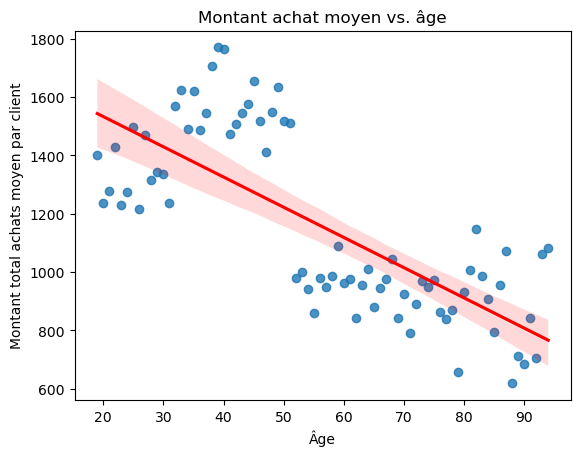

Coefficient de corrélation de Spearman : -0.725058099794942
Valeur p : 1.3005339826531928e-13

Les variables sont corrélées (on rejette H0)


In [90]:
# Version alternative : 1 observation = 1 âge

data = df_CAclient.loc[df_CAclient['CA']<1e5][["age","CA"]]

# On fait la moyenne des montants total d'achat par âge
data = (data.groupby("age")["CA"].mean()).reset_index()

# Visualisation de la tendance
sb.regplot(data=data, x="age", y="CA", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Montant total achats moyen par client")
plt.title("Montant achat moyen vs. âge")
plt.savefig("CA_age_moyen.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["CA"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

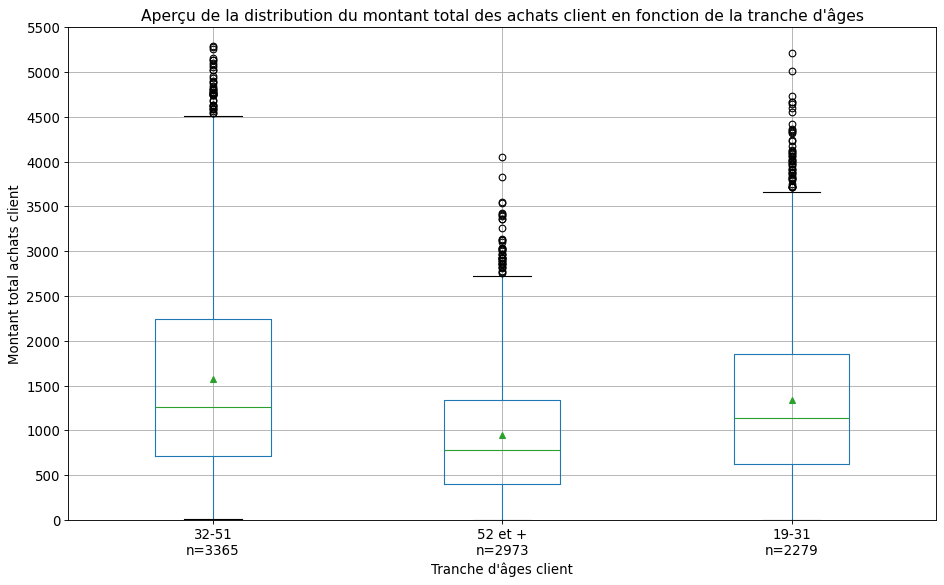

In [91]:
# Corrélation en substituant l'âge par la tranche d'âge
# 1 observation = 1 client

data = df_CAclient.loc[df_CAclient['CA']<1e5][["tranche","CA"]]

# Boîtes à moustaches pour l'analyse des prix selon la catégorie des produits
L_tranche = list(data.groupby('tranche').count().sort_values("CA",ascending=False).index)

fig = plt.figure(figsize=(14,8), dpi=80)

for i in np.arange(len(L_tranche)):
    tranche = L_tranche[i]
    data.loc[data["tranche"] == tranche].boxplot(column=["CA"], positions=[i], widths=[0.4], showmeans=True)
    L_tranche[i] = tranche + "\n" + "n="+str(len(data.loc[data["tranche"] == tranche]))

plt.xticks(ticks=np.arange(len(L_tranche)), labels=L_tranche, fontsize=12)
plt.xlabel("Tranche d'âges client", fontsize=12)
plt.ylabel("Montant total achats client", fontsize=12)
plt.xlim([-0.5,len(L_tranche)-0.5])
plt.ylim([0,5500])
plt.yticks(ticks=np.linspace(0,5500,12),fontsize=12)
plt.title("Aperçu de la distribution du montant total des achats client en fonction de la tranche d'âges", fontsize=14)
plt.savefig("CA_trancheage.png")
plt.show()

In [92]:
# Test H de Kruskal-Wallis pour déceler un éventuel effet statistque de la tranche d'âges sur le montant total d'achats client
# Hypothèse H0 : les CA clients des différentes tranches d'âges proviennent de la même distribution
# Hypothèse H1 : la tranche d'âges a un impact sur le montant total des achats
   
data = data.sort_values(by="CA", ascending=True)

H, p = st.kruskal(data.loc[data["tranche"] == "19-31"]["CA"],\
                  data.loc[data["tranche"] == "32-51"]["CA"],\
                  data.loc[data["tranche"] == "52 et +"]["CA"])

print("Statistique H =",H)
print(f"Valeur p : {p}")

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("Les montants totaux d'achats des clients des différentes tranches d'âges proviennent de la même distribution (on ne rejette pas H0)")
else:
    print("Les montants totaux d'achats des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)")

Statistique H = 615.1182733433617
Valeur p : 2.6838861214013115e-134
Les montants totaux d'achats des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.3 - Âge des clients et fréquence des achats</h3>
</div>

In [93]:
# La fréquence d'achat s'obtient en calculant le nombre de sessions différentes effectuées par un même client
# On enlève les clients BtoB, qui ont un nombre de sessions supérieur à 1000
data = (df_Sessions_Clients.loc[df_Sessions_Clients['nb_sessions']<1e3])
#display(df_Sessions_Clients.loc[df_Sessions_Clients['nb_sessions']>1e3])
data = data.drop(columns=["sex","client_id"])
display(data)

,age,tranche,nb_sessions
0,56,52 et +,52
1,48,32-51,20
2,39,32-51,6
3,61,52 et +,58
4,80,52 et +,18
...,...,...,...
8616,67,52 et +,48
8617,53,52 et +,123
8618,49,32-51,25
8619,55,52 et +,95


On a vu précédemment que l'âge ne suivait pas une loi normale. On va donc utiliser le test de corrélation de Spearman.<br>
Hypothèse (H0) : les 2 variables ne sont pas corrélées.

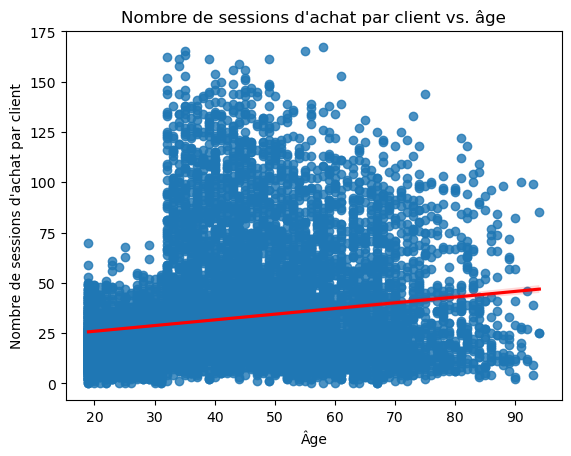

Coefficient de corrélation de Spearman : 0.2124282266506788
Valeur p : 1.6757272106322822e-88

Les variables sont corrélées (on rejette H0)


In [94]:
# 1 observation = 1 client

# Visualisation de la tendance
sb.regplot(data=data, x="age", y="nb_sessions", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Nombre de sessions d'achat par client")
plt.title("Nombre de sessions d'achat par client vs. âge")
plt.savefig("NbSessions_age.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["nb_sessions"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

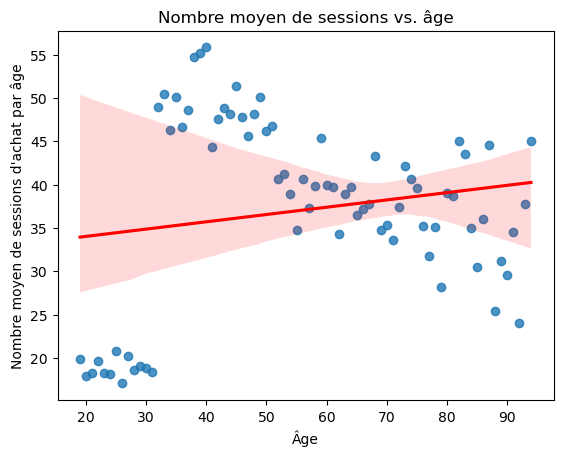

Coefficient de corrélation de Spearman : -0.0027067854189656176
Valeur p : 0.9814858234324102

Les variables ne sont pas corrélées (on ne rejette pas H0)


In [95]:
# 1 observation = 1 âge

# On fait la moyenne des montants total d'achat par âge
data = (data.groupby("age")["nb_sessions"].mean()).reset_index()

# Visualisation de la tendance
sb.regplot(data=data, x="age", y="nb_sessions", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Nombre moyen de sessions d'achat par âge")
plt.title("Nombre moyen de sessions vs. âge")
plt.savefig("NbSessions_age_moyen.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["nb_sessions"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

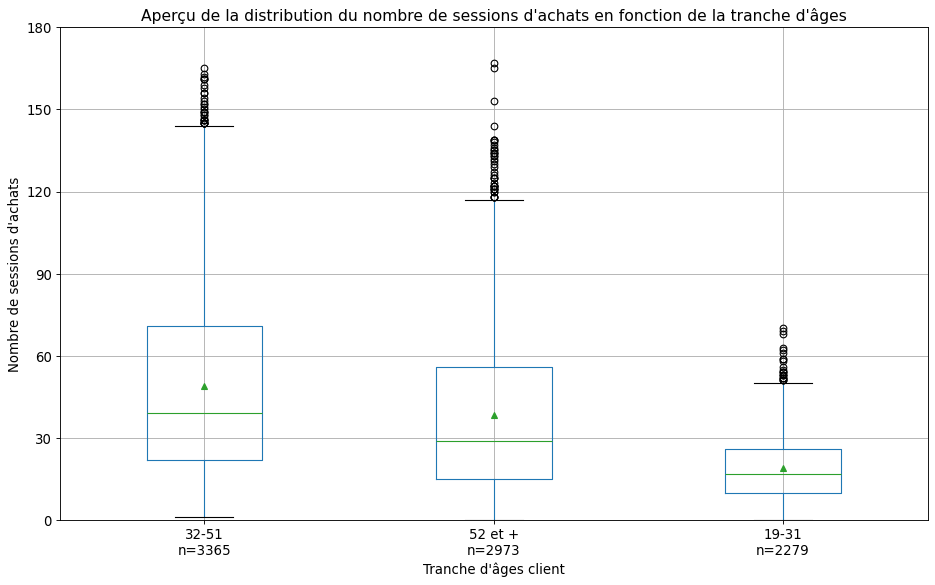

In [96]:
# Corrélation en substituant l'âge par la tranche d'âge
# 1 observation = 1 client

# On enlève les clients BtoB, qui ont un nombre de sessions supérieur à 1000
data = (df_Sessions_Clients.loc[df_Sessions_Clients['nb_sessions']<1e3])
#display(df_Sessions_Clients.loc[df_Sessions_Clients['nb_sessions']>1e3])
data = data.drop(columns=["sex","client_id"])

# Boîtes à moustaches pour l'analyse des prix selon la catégorie des produits
L_tranche = list(data.groupby('tranche').count().sort_values("nb_sessions",ascending=False).index)

fig = plt.figure(figsize=(14,8), dpi=80)

for i in np.arange(len(L_tranche)):
    tranche = L_tranche[i]
    data.loc[data["tranche"] == tranche].boxplot(column=["nb_sessions"], positions=[i], widths=[0.4], showmeans=True)
    L_tranche[i] = tranche + "\n" + "n="+str(len(data.loc[data["tranche"] == tranche]))

plt.xticks(ticks=np.arange(len(L_tranche)), labels=L_tranche, fontsize=12)
plt.xlabel("Tranche d'âges client", fontsize=12)
plt.ylabel("Nombre de sessions d'achats", fontsize=12)
plt.xlim([-0.5,len(L_tranche)-0.5])
plt.ylim([0,180])
plt.yticks(ticks=np.linspace(0,180,7),fontsize=12)
plt.title("Aperçu de la distribution du nombre de sessions d'achats en fonction de la tranche d'âges", fontsize=14)
plt.savefig("NbSessions_trancheage.png")
plt.show()

In [97]:
# Test H de Kruskal-Wallis pour déceler un éventuel effet statistque de la tranche d'âges sur le nombre de sessions d'achats
# Hypothèse H0 : les nombres de sessions d'achats des différentes tranches d'âges proviennent de la même distribution
# Hypothèse H1 : la tranche d'âges a un impact sur le nombre de sessions d'achats
   
data = data.sort_values(by="nb_sessions", ascending=True)

H, p = st.kruskal(data.loc[data["tranche"] == "19-31"]["nb_sessions"],\
                  data.loc[data["tranche"] == "32-51"]["nb_sessions"],\
                  data.loc[data["tranche"] == "52 et +"]["nb_sessions"])

print("Statistique H =",H)
print(f"Valeur p : {p}")

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("Les nombres de sessions d'achats des clients des différentes tranches d'âges proviennent de la même distribution (on ne rejette pas H0)")
else:
    print("Les nombres de sessions d'achats des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)")

Statistique H = 1435.4954958803753
Valeur p : 0.0
Les nombres de sessions d'achats des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.4 - Âge des clients et taille du panier moyen</h3>
</div>

La taille d'un panier correspond au nombre d'articles (ou de lignes) pour une session d'achat donnée.<br>
Pour obtenir la taille du panier moyen d'un client donné, il faut calculer la moyenne des tailles de panier sur toutes ses sessions d'achat.

In [98]:
data_prod_sess = df_ventes.groupby(["client_id","session_id"])["id_prod"].count().reset_index()
data_prod_sess.rename(columns={"id_prod": "nb_items"}, inplace=True)
display(data_prod_sess)
# On utilise une jointure interne pour ne conserver que les clients non BtoB ayant réalisé au moins un achat
data_tmp = data_prod_sess.merge(df_clients_corr, how='inner', left_on='client_id', right_on='client_id')
display(data_tmp)
data = data_tmp.groupby(["client_id","age","tranche"])["nb_items"].mean().reset_index().sort_values("nb_items",ascending=False)
display(data)

,client_id,session_id,nb_items
0,c_1,s_101417,1
1,c_1,s_105105,4
2,c_1,s_114737,5
3,c_1,s_120172,2
4,c_1,s_134971,1
...,...,...,...
345500,c_999,s_88239,1
345501,c_999,s_89648,1
345502,c_999,s_92374,1
345503,c_999,s_98289,1


,client_id,session_id,nb_items,sex,age,tranche
0,c_1,s_101417,1,M,68,52 et +
1,c_1,s_105105,4,M,68,52 et +
2,c_1,s_114737,5,M,68,52 et +
3,c_1,s_120172,2,M,68,52 et +
4,c_1,s_134971,1,M,68,52 et +
...,...,...,...,...,...,...
322461,c_999,s_88239,1,M,59,52 et +
322462,c_999,s_89648,1,M,59,52 et +
322463,c_999,s_92374,1,M,59,52 et +
322464,c_999,s_98289,1,M,59,52 et +


,client_id,age,tranche,nb_items
7899,c_8127,35,32-51,8.200000
2371,c_3136,39,32-51,6.000000
387,c_1348,26,19-31,6.000000
7295,c_7583,39,32-51,5.500000
7871,c_8101,30,19-31,5.333333
...,...,...,...,...
5865,c_6292,31,19-31,1.000000
5858,c_6286,25,19-31,1.000000
8308,c_8498,24,19-31,1.000000
5855,c_6283,55,52 et +,1.000000


Remarque : la taille d'un panier est un entier supérieur ou égal à 1. Donc les tailles moyennes de panier sont des réels supérieurs ou égaux à 1.

Moyenne des tailles de panier moyen : 1.98
Premier quartile des tailles de panier moyen : 1.42
Médiane des tailles de panier moyen : 1.96
Troisième quartile des tailles de panier moyen : 2.42

Nombre de clients avec une taille de panier moyen atypique (au moins 3.92 ) : 75

Nombre de clients avec un nombre de sessions très atypique (au moins 5.42 ) : 4 



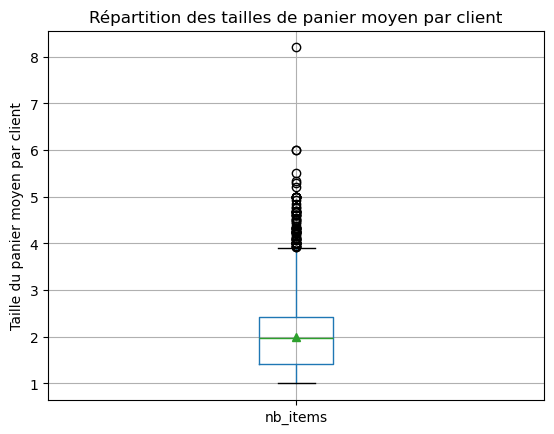

In [99]:
# Étudions la distribution des tailles de panier moyen

print("Moyenne des tailles de panier moyen :",round(data["nb_items"].mean(),2))

Q1 = round(data["nb_items"].quantile(0.25),2)
Q3 = round(data["nb_items"].quantile(0.75),2)

print("Premier quartile des tailles de panier moyen :",Q1)
print("Médiane des tailles de panier moyen :",round(data["nb_items"].quantile(0.5),2))
print("Troisième quartile des tailles de panier moyen :",Q3)

print("\nNombre de clients avec une taille de panier moyen atypique (au moins",\
      round(Q3+1.5*(Q3-Q1),2),") :",\
      data.loc[data["nb_items"]>=Q3+1.5*(Q3-Q1)].shape[0])

print("\nNombre de clients avec un nombre de sessions très atypique (au moins",\
      round(Q3+3*(Q3-Q1),2),") :",\
      data.loc[data["nb_items"]>=Q3+3*(Q3-Q1)].shape[0],"\n")

data.boxplot(column=["nb_items"],showmeans=True)
plt.ylabel("Taille du panier moyen par client")
#plt.ylim([-10,200])
plt.title("Répartition des tailles de panier moyen par client")
plt.show()

Moyenne taille de panier moyen : 1.98
Écart type des tailles de panier moyen : 0.65


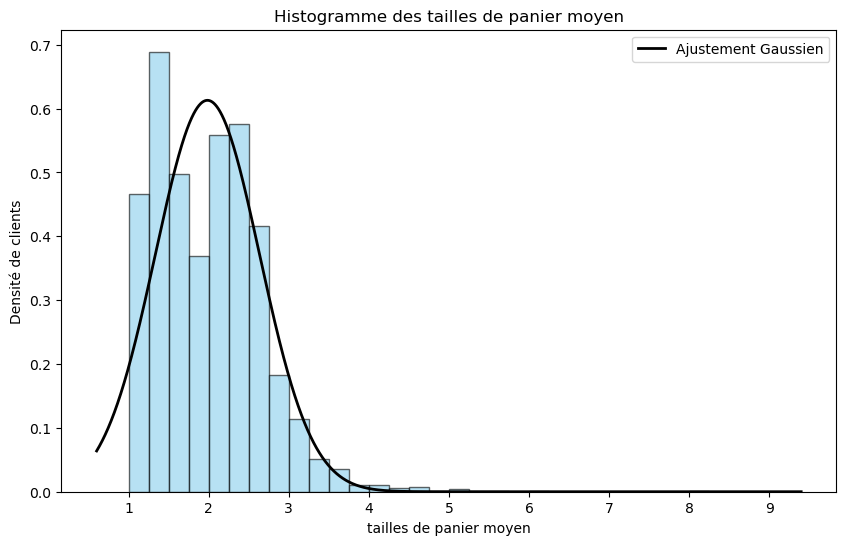

Statistique du test de Shapiro-Wilk : 0.9463335195128412
Valeur p : 2.996570974880341e-48
Les données ne suivent pas une distribution normale (on rejette H0)


C:\Users\nicol\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8596.
  res = hypotest_fun_out(*samples, **kwds)


In [100]:
y = data['nb_items']

# Estimer la moyenne et l'écart type
mean_y = y.mean()
std_y = y.std(ddof=1)    # Estimateur sans biais

# Afficher les valeurs calculées
print(f"Moyenne taille de panier moyen : {round(mean_y,2)}")
print(f"Écart type des tailles de panier moyen : {round(std_y,2)}")

# Tracer l'histogramme avec une courbe gaussienne
plt.figure(figsize=(10, 6))

# Histogramme
plt.hist(y, bins=np.linspace(1,9,33), density=True, color='skyblue', edgecolor='black', alpha=0.6)

# Ajustement gaussien
mu, std = st.norm.fit(y)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, y.count())
p = st.norm.pdf(x, mu, std)

# Tracer la courbe gaussienne
plt.plot(x, p, 'k', linewidth=2, label='Ajustement Gaussien')

# Ajouter les titres et légendes en français
plt.title("Histogramme des tailles de panier moyen")
plt.xlabel('tailles de panier moyen')
plt.xticks(np.linspace(1,9,9))
plt.ylabel('Densité de clients')
plt.legend()

# Afficher le graphique
plt.show()

# Test de Shapiro-Wilk
stat, p_value = st.shapiro(y)

# Afficher les résultats
print(f"Statistique du test de Shapiro-Wilk : {stat}")
print(f"Valeur p : {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (on ne rejette pas H0)")
else:
    print("Les données ne suivent pas une distribution normale (on rejette H0)")

Ni l'âge des clients ni la taille de panier moyen ne suit une loi normale. On va donc utiliser le test de corrélation de Spearman.<br>
Hypothèse (H0) : les 2 variables ne sont pas corrélées.

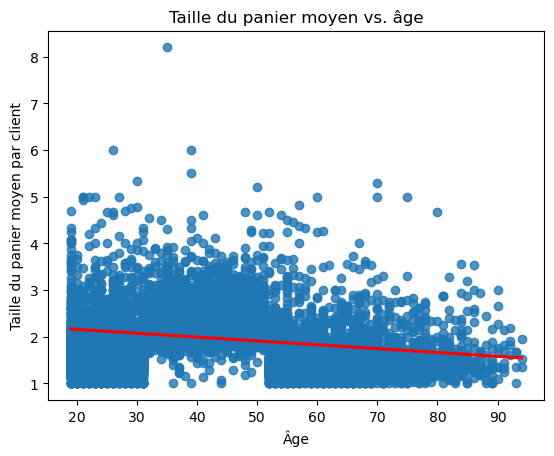

Coefficient de corrélation de Spearman : -0.2077153303501514
Valeur p : 2.0454404776384444e-84

Les variables sont corrélées (on rejette H0)


In [101]:
# 1 observation = 1 client

# Visualisation de la tendance
sb.regplot(data=data, x="age", y="nb_items", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Taille du panier moyen par client")
plt.title("Taille du panier moyen vs. âge")
plt.savefig("NbItems_age.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["nb_items"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

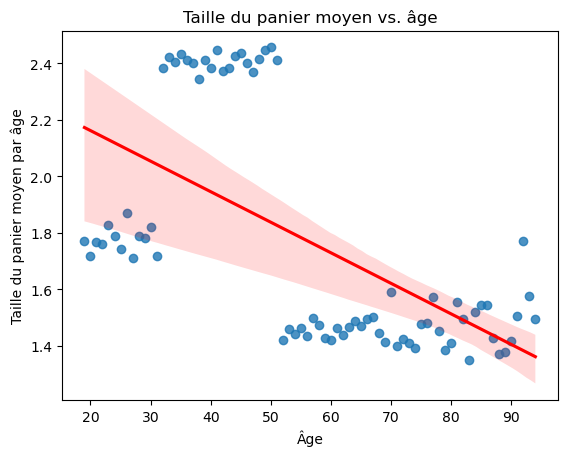

Coefficient de corrélation de Spearman : -0.6337115516062884
Valeur p : 8.031013669610673e-10

Les variables sont corrélées (on rejette H0)


In [102]:
# 1 observation = 1 âge
data = data_tmp.groupby("age")["nb_items"].mean().reset_index().sort_values("nb_items",ascending=False)

# Visualisation de la tendance
sb.regplot(data=data, x="age", y="nb_items", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Taille du panier moyen par âge")
plt.title("Taille du panier moyen vs. âge")
plt.savefig("NbItems_age_moyen.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["nb_items"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

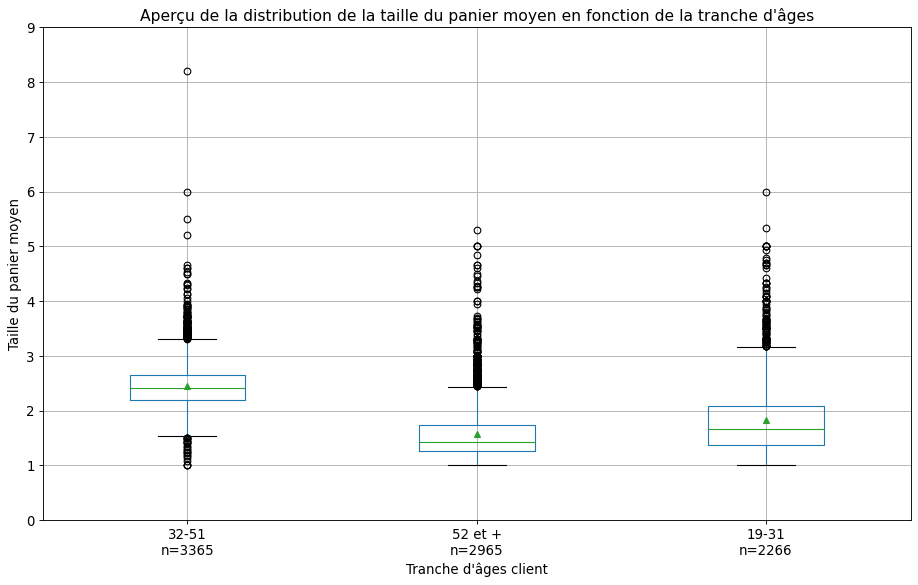

In [103]:
# Corrélation en substituant l'âge par la tranche d'âge
# 1 observation = 1 client

data = data_tmp.groupby(["client_id","age","tranche"])["nb_items"].mean().reset_index().sort_values("nb_items",ascending=False)

# Boîtes à moustaches pour l'analyse des prix selon la catégorie des produits
L_tranche = list(data.groupby('tranche').count().sort_values("nb_items",ascending=False).index)

fig = plt.figure(figsize=(14,8), dpi=80)

for i in np.arange(len(L_tranche)):
    tranche = L_tranche[i]
    data.loc[data["tranche"] == tranche].boxplot(column=["nb_items"], positions=[i], widths=[0.4], showmeans=True)
    L_tranche[i] = tranche + "\n" + "n="+str(len(data.loc[data["tranche"] == tranche]))

plt.xticks(ticks=np.arange(len(L_tranche)), labels=L_tranche, fontsize=12)
plt.xlabel("Tranche d'âges client", fontsize=12)
plt.ylabel("Taille du panier moyen", fontsize=12)
plt.xlim([-0.5,len(L_tranche)-0.5])
plt.ylim([0,9])
plt.yticks(ticks=np.linspace(0,9,10),fontsize=12)
plt.title("Aperçu de la distribution de la taille du panier moyen en fonction de la tranche d'âges", fontsize=14)
plt.savefig("NbItems_trancheage.png")
plt.show()

In [104]:
# Test H de Kruskal-Wallis pour déceler un éventuel effet statistque de la tranche d'âges sur la taille du panier moyen
# Hypothèse H0 : les tailles de panier moyen des différentes tranches d'âges proviennent de la même distribution
# Hypothèse H1 : la tranche d'âges a un impact sur la taille du panier moyen
   
data = data.sort_values(by="nb_items", ascending=True)

H, p = st.kruskal(data.loc[data["tranche"] == "19-31"]["nb_items"],\
                  data.loc[data["tranche"] == "32-51"]["nb_items"],\
                  data.loc[data["tranche"] == "52 et +"]["nb_items"])

print("Statistique H =",H)
print(f"Valeur p : {p}")

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("Les tailles de panier moyen des clients des différentes tranches d'âges proviennent de la même distribution (on ne rejette pas H0)")
else:
    print("Les tailles de panier moyen des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)")

Statistique H = 3746.207299400984
Valeur p : 0.0
Les tailles de panier moyen des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.5 - Âge des clients et catégories de produits achetés</h3>
</div>

In [105]:
# On a déjà les données qui nous intéressent dans le DataFrame datanb
display(datanb)

# Pour chaque client, on va déterminer le nombre de produits qu'il a achetés
contingency_table = pd.crosstab(datanb['age'], datanb['categ'])

# Calculer le test du Chi-2
# Hypothèse H0 : il y a indépendance entre catégorie de produits acheté et sexe
chi2_stat, p_value, dof, expected = st.chi2_contingency(contingency_table)

print(f"Statistique Chi-2: {chi2_stat}")
print(f"Valeur p: {p_value}")
print(f"Degrés de liberté: {dof}")
print("\nFréquences attendues:")
print(expected)
print("")
print(contingency_table)

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("\nLes variables sont indépendantes (on ne rejette pas H0)")
else:
    print("\nLes variables ne sont pas indépendantes (on rejette H0)")

,client_id,sex,age,tranche,id_prod,date,session_id,CA,categ,nombre
0,c_4410,F,56,52 et +,1_483,2021-03-13,s_5913,15.99,1,1
1,c_4410,F,56,52 et +,0_1455,2021-03-22,s_9942,8.99,0,1
2,c_4410,F,56,52 et +,0_1420,2021-03-22,s_10092,11.53,0,1
3,c_4410,F,56,52 et +,0_1111,2021-03-22,s_9707,19.99,0,1
4,c_4410,F,56,52 et +,1_385,2021-03-22,s_9707,25.99,1,1
...,...,...,...,...,...,...,...,...,...,...
640729,c_84,F,41,32-51,0_1472,2022-05-14,s_208110,12.49,0,1
640730,c_84,F,41,32-51,0_1438,2022-05-29,s_215697,9.31,0,1
640731,c_84,F,41,32-51,1_688,2022-12-17,s_313173,18.19,1,1
640732,c_84,F,41,32-51,1_459,2022-12-17,s_313173,15.99,1,1


Statistique Chi-2: 273539.8180441075
Valeur p: 0.0
Degrés de liberté: 150

Fréquences attendues:
[[9.36690367e+03 5.33562396e+03 7.94472365e+02]
 [2.71451019e+03 1.54625329e+03 2.30236522e+02]
 [2.84748553e+03 1.62199939e+03 2.41515087e+02]
 [2.64620922e+03 1.50734734e+03 2.24443441e+02]
 [2.73747866e+03 1.55933671e+03 2.32184638e+02]
 [3.12310713e+03 1.77900039e+03 2.64892476e+02]
 [3.01310026e+03 1.71633771e+03 2.55562027e+02]
 [2.93029290e+03 1.66916855e+03 2.48538557e+02]
 [3.74567349e+03 2.13362984e+03 3.17696667e+02]
 [3.51054891e+03 1.99969697e+03 2.97754113e+02]
 [3.20228790e+03 1.82410375e+03 2.71608349e+02]
 [2.83962789e+03 1.61752348e+03 2.40848627e+02]
 [3.59456515e+03 2.04755473e+03 3.04880116e+02]
 [1.02366833e+04 5.83107230e+03 8.68244432e+02]
 [1.09360127e+04 6.22942791e+03 9.27559430e+02]
 [9.96710599e+03 5.67751430e+03 8.45379705e+02]
 [1.52589200e+04 8.69186468e+03 1.29421532e+03]
 [1.19816824e+04 6.82506768e+03 1.01624996e+03]
 [1.43208394e+04 8.15751039e+03 1.21465

,age,Catégorie,part_categ
0,19,0,22.055882
1,20,0,20.240481
2,21,0,21.566546
3,22,0,22.247602
4,23,0,24.597041
...,...,...,...
223,90,2,0.297619
224,91,2,0.641026
225,92,2,1.176471
226,93,2,0.840336


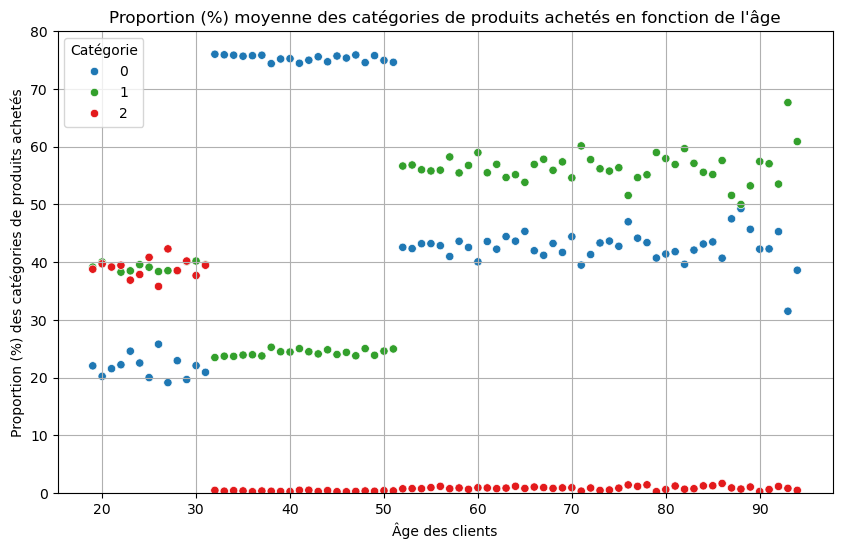

In [106]:
# 1 observation = 1 âge

table = contingency_table.reset_index()

table["total"] = sum([table[i] for i in list(df_products["categ"].unique())])

for i in list(df_products["categ"].unique()):
    table[i] = 100*table[i]/table["total"]

df_toplot = pd.melt(table, id_vars=['age'], value_vars=[i for i in list(df_products["categ"].unique())],\
                    var_name='Catégorie', value_name='part_categ')

#uni_cont_table.rename(columns={i: "categ "+str(i) for i in list(df_products["categ"].unique())}, inplace=True)

display(df_toplot)

plt.figure(figsize=(10, 6))

sb.scatterplot(data=df_toplot, x='age', y='part_categ', hue='Catégorie',\
               palette=[cm['Paired'](2*i+1) for i in list(df_products["categ"].unique())])
plt.xlabel("Âge des clients")
plt.ylabel("Proportion (%) des catégories de produits achetés")
plt.ylim([0,80])
plt.title("Proportion (%) moyenne des catégories de produits achetés en fonction de l'âge")
plt.grid(True)
plt.savefig("Categ_age.png")
plt.show()

Grâce au graphique ci-dessus, on distingue très nettement 3 tranches d'âges pour lesquels les comportements clients sont radicalement différents :
- de 19 à 31 ans, les clients achètent environ 20-25% de produits de catégorie 0, et autour de 40% chacun de produits de catégories 1 et 2 ;
- de 32 à 51 ans, les clients n'achètent quasiment pas de produits de catégorie 2, environ 25% de produits de catégorie 1 et 75% de produits de catégorie 0 ;
- à partir de 52 ans, les clients n'achètent quasiment pas de produits de catégorie 2, environ 45% de produits de catégorie 0 et 55% de produits de catégorie 1.<br>

**Remarque importante** : le graphique précédent ne raisonne pas par client, mais pour un âge donné sur l'ensemble des clients, comme si tous les clients d'un âge donné n'étaient qu'un seul client. Ceci est la seule façon raisonnable d'agréger les **quantités d'articles** achetées pour chaque catégorie.

,client_id,sex,age,tranche,id_prod,date,session_id,CA,categ,nombre
0,c_4410,F,56,52 et +,1_483,2021-03-13,s_5913,15.99,1,1
1,c_4410,F,56,52 et +,0_1455,2021-03-22,s_9942,8.99,0,1
2,c_4410,F,56,52 et +,0_1420,2021-03-22,s_10092,11.53,0,1
3,c_4410,F,56,52 et +,0_1111,2021-03-22,s_9707,19.99,0,1
4,c_4410,F,56,52 et +,1_385,2021-03-22,s_9707,25.99,1,1
...,...,...,...,...,...,...,...,...,...,...
640729,c_84,F,41,32-51,0_1472,2022-05-14,s_208110,12.49,0,1
640730,c_84,F,41,32-51,0_1438,2022-05-29,s_215697,9.31,0,1
640731,c_84,F,41,32-51,1_688,2022-12-17,s_313173,18.19,1,1
640732,c_84,F,41,32-51,1_459,2022-12-17,s_313173,15.99,1,1


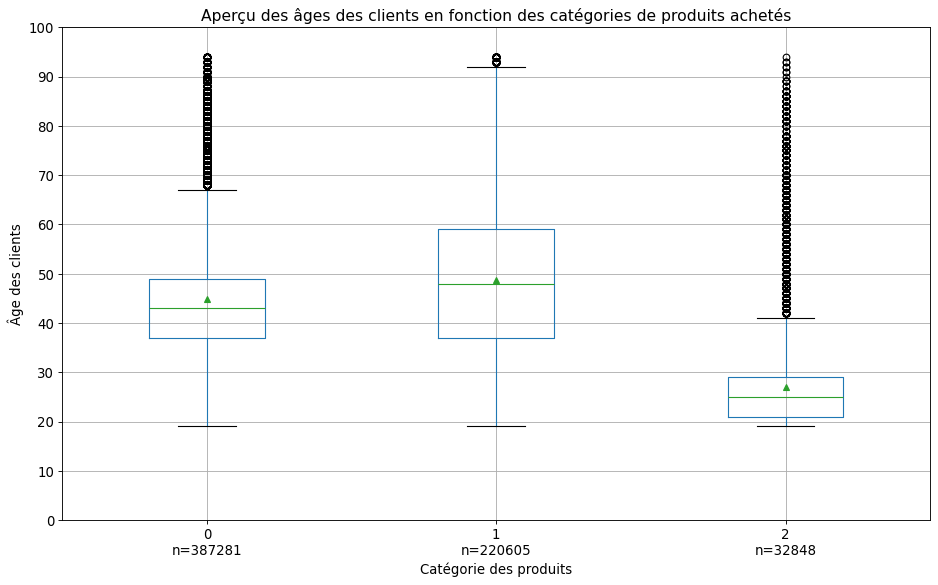

In [107]:
# 1 observation = 1 transaction càd 1 produit (1 catégorie) & 1 client

display(datanb)

# Boîtes à moustaches pour l'analyse des prix selon la catégorie des produits
L_cat = list(datanb.groupby('categ').count().sort_values(by="id_prod",ascending=False).index)

fig = plt.figure(figsize=(14,8), dpi=80)

for i in np.arange(len(L_cat)):
    cat = L_cat[i]
    datanb.loc[datanb["categ"] == cat].boxplot(column=["age"],\
                                                        positions=[i], widths=[0.4], showmeans=True)
    L_cat[i] = str(cat) + "\n" + "n="+str(len(datanb.loc[datanb["categ"] == cat]))

plt.xticks(ticks=np.arange(len(L_cat)), labels=L_cat, fontsize=12)
plt.xlabel("Catégorie des produits", fontsize=12)
plt.ylabel("Âge des clients", fontsize=12)
plt.xlim([-0.5,len(L_cat)-0.5])
plt.ylim([0,100])
plt.yticks(ticks=np.linspace(0,100,11),fontsize=12)
plt.title("Aperçu des âges des clients en fonction des catégories de produits achetés", fontsize=14)
plt.savefig("catage.png")
plt.show()

In [108]:
# Test H de Kruskal-Wallis pour déceler un éventuel effet statistque de la catégorie sur l'âge des clients
# Hypothèse H0 : Les âges des clients achetant des produits des catégories 0, 1 et 2 proviennent de la même distribution
# Hypothèse H1 : la catégorie a une influence directe sur l'âge des clients qui les achètent
   

H, p = st.kruskal(datanb.loc[datanb["categ"] == 0]["age"],\
                  datanb.loc[datanb["categ"] == 1]["age"],\
                  datanb.loc[datanb["categ"] == 2]["age"])

print("Statistique H =",H)
print(f"Valeur p : {p}")

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("Les âges des clients selon les catégories de produits qu'ils achètent proviennent de la même distribution (on ne rejette pas H0)")
else:
    print("Les âges des clients selon les catégories de produits qu'ils achètent ne proviennent pas de la même distribution (on rejette H0)")

Statistique H = 71359.73412120914
Valeur p : 0.0
Les âges des clients selon les catégories de produits qu'ils achètent ne proviennent pas de la même distribution (on rejette H0)


In [109]:
# Test ANOVA pour déceler un éventuel effet statistque de la catégorie sur l'âge des clients
# On suppose que l'âge des clients achetant des produits des 0, 1 et 2 suivent des lois normales (pour chaque catégorie) ayant la même variance
# Ce qui ne semble pas être le cas nous concernant
# Hypothèse H0 : Les âges des clients achetant des produits des catégories 0, 1 et 2 suivent des lois normales (pour chaque catégorie) ayant la même moyenne
# Hypothèse H1 : Les âges des clients achetant des produits des catégories 0, 1 et 2 ne suivent pas la même loi normale

# Calculer le test ANOVA et la valeur p
f_stat, p_value = st.f_oneway(datanb.loc[datanb["categ"] == 0]["age"],\
                              datanb.loc[datanb["categ"] == 1]["age"],\
                              datanb.loc[datanb["categ"] == 2]["age"])

print(f"Statistique de test F: {f_stat}")
print(f"Valeur p: {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("\nLes variables sont indépendantes (on ne rejette pas H0)")
else:
    print("\nLes variables ne sont pas indépendantes (on rejette H0)")

Statistique de test F: 39705.51969324279
Valeur p: 0.0

Les variables ne sont pas indépendantes (on rejette H0)


In [110]:
contingency_table = pd.crosstab(datanb['tranche'], datanb['categ'])

# Calculer le test du Chi-2
# Hypothèse H0 : il y a indépendance entre catégorie de produits acheté et sexe
chi2_stat, p_value, dof, expected = st.chi2_contingency(contingency_table)

print(f"Statistique Chi-2: {chi2_stat}")
print(f"Valeur p: {p_value}")
print(f"Degrés de liberté: {dof}")
print("\nFréquences attendues:")
print(expected)
print("")
print(contingency_table)

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("\nLes variables sont indépendantes (on ne rejette pas H0)")
else:
    print("\nLes variables ne sont pas indépendantes (on rejette H0)")

Statistique Chi-2: 272890.7630841266
Valeur p: 0.0
Degrés de liberté: 4

Fréquences attendues:
[[ 46271.79090543  26357.57610803   3924.63298654]
 [240077.3012108  136754.07012895  20362.62866026]
 [100931.90788377  57493.35376303   8560.7383532 ]]

categ         0      1      2
tranche                      
19-31     16691  29984  29879
32-51    299245  96474   1475
52 et +   71345  94147   1494

Les variables ne sont pas indépendantes (on rejette H0)


,0,1,2
19-31,21.802910,39.167124,39.029966
32-51,75.339758,24.288887,0.371355
52 et +,42.725139,56.380176,0.894686
Total,60.443335,34.430044,5.126620


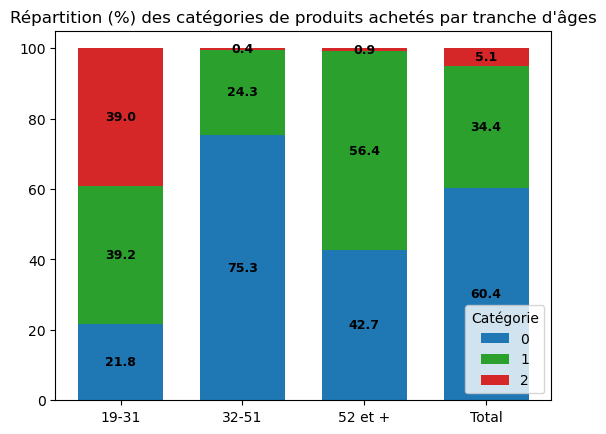

In [111]:
table = contingency_table
total = pd.DataFrame([{i: table[i].sum() for i in list(df_products["categ"].unique())}],index=["Total"])
table = pd.concat([table,total],axis=0)
table["total"] = table.sum(axis=1)
for i in list(df_products["categ"].unique()):
    table[i] = 100*table[i]/table["total"]
table.drop(["total"],axis=1, inplace=True)
display(table)

# Graphique en barres empilées 100%

fig, ax = plt.subplots()
bottom = np.zeros(4)

for boolean, x in table.items():
    p = ax.bar(list(table.index), x, width=0.7, label=boolean, bottom=bottom,\
               color=df_couleurs.loc[df_couleurs['categ']==(x.name)]["couleur"])
    plt.bar_label(p, label_type='center', fmt='%.1f', fontsize=9, fontweight='bold')
    bottom += x

ax.set_title("Répartition (%) des catégories de produits achetés par tranche d'âges")
ax.legend(title="Catégorie",loc="lower right")
plt.ylim([0,105])
plt.yticks(np.linspace(0,100,6))

plt.savefig("Categ_tranche_stacked.png")
plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">4.6 - Âge des clients et montant moyen du panier</h3>
</div>

In [112]:
# On agrège d'abord les montants totaux par session,
df_CA_sess = df_achats.groupby(["client_id","session_id"])["CA"].sum().reset_index()
# puis on agrège par client en calculant la moyenne des CA par session
df_CAmoy_sess = df_CA_sess.groupby("client_id")["CA"].mean().reset_index()
df_CAmoy_sess.rename(columns={"CA": "CA_moy"}, inplace=True)
data = df_CAmoy_sess.merge(df_clients_corr, how='inner', left_on='client_id', right_on='client_id')
display(data)

,client_id,CA_moy,sex,age,tranche
0,c_1,18.500588,M,68,52 et +
1,c_10,39.811765,M,67,52 et +
2,c_100,50.970000,M,31,19-31
3,c_1000,24.381702,F,57,52 et +
4,c_1001,38.805319,M,41,32-51
...,...,...,...,...,...
8591,c_995,21.045556,M,68,52 et +
8592,c_996,20.466750,F,53,52 et +
8593,c_997,62.083750,F,29,19-31
8594,c_998,117.592500,M,22,19-31


Moyenne des montants des paniers moyens : 40.4
Premier quartile des montants de panier moyen : 25.76
Médiane des montants de panier moyen : 32.34
Troisième quartile des montants de panier moyen : 48.31

Nombre de clients avec un montant de panier moyen atypique (au moins 82.14 €) : 576

Nombre de clients avec un montant de panier moyen très atypique (au moins 115.96 €) : 91 



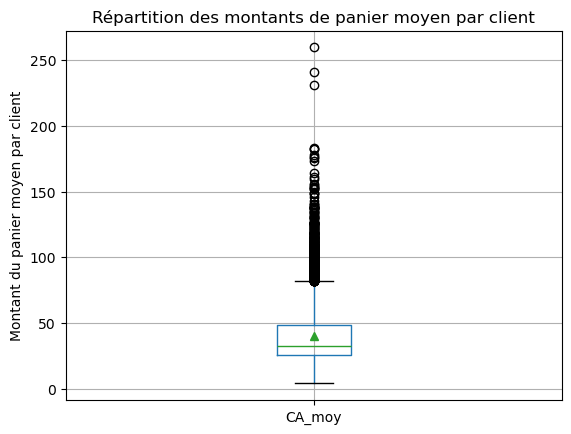

In [113]:
# Étudions la distribution des montants des paniers moyens par client

print("Moyenne des montants des paniers moyens :",round(data["CA_moy"].mean(),2))

Q1 = round(data["CA_moy"].quantile(0.25),2)
Q3 = round(data["CA_moy"].quantile(0.75),2)

print("Premier quartile des montants de panier moyen :",Q1)
print("Médiane des montants de panier moyen :",round(data["CA_moy"].quantile(0.5),2))
print("Troisième quartile des montants de panier moyen :",Q3)

print("\nNombre de clients avec un montant de panier moyen atypique (au moins",\
      round(Q3+1.5*(Q3-Q1),2),"€) :",\
      data.loc[data["CA_moy"]>=Q3+1.5*(Q3-Q1)].shape[0])

print("\nNombre de clients avec un montant de panier moyen très atypique (au moins",\
      round(Q3+3*(Q3-Q1),2),"€) :",\
      data.loc[data["CA_moy"]>=Q3+3*(Q3-Q1)].shape[0],"\n")

data.boxplot(column=["CA_moy"],showmeans=True)
plt.ylabel("Montant du panier moyen par client")
#plt.ylim([-10,200])
plt.title("Répartition des montants de panier moyen par client")
plt.show()

Moyenne montant de panier moyen : 40.4
Écart type des montants de panier moyen : 22.76


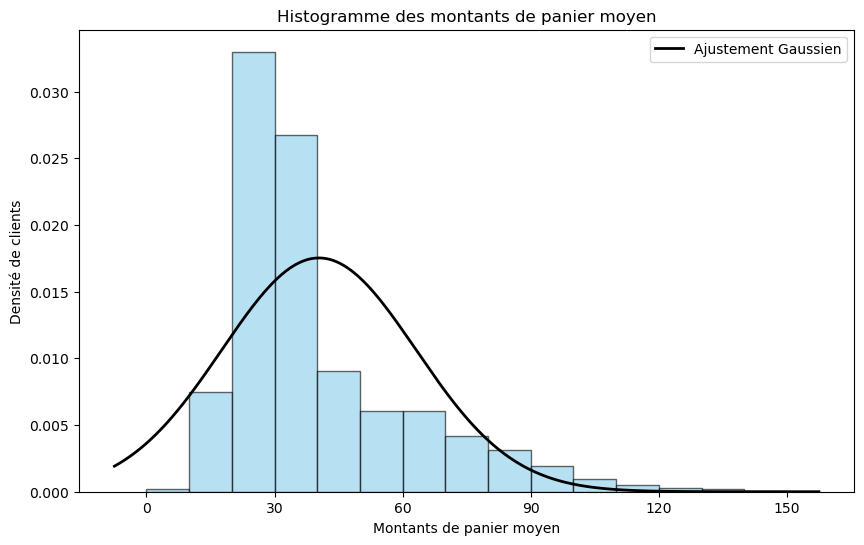

Statistique du test de Shapiro-Wilk : 0.8171618357060995
Valeur p : 2.641765504625105e-71
Les données ne suivent pas une distribution normale (on rejette H0)


C:\Users\nicol\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8596.
  res = hypotest_fun_out(*samples, **kwds)


In [114]:
y = data['CA_moy']

# Estimer la moyenne et l'écart type
mean_y = y.mean()
std_y = y.std(ddof=1)    # Estimateur sans biais

# Afficher les valeurs calculées
print(f"Moyenne montant de panier moyen : {round(mean_y,2)}")
print(f"Écart type des montants de panier moyen : {round(std_y,2)}")

# Tracer l'histogramme avec une courbe gaussienne
plt.figure(figsize=(10, 6))

# Histogramme
plt.hist(y, bins=np.linspace(0,150,16), density=True, color='skyblue', edgecolor='black', alpha=0.6)

# Ajustement gaussien
mu, std = st.norm.fit(y)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, y.count())
p = st.norm.pdf(x, mu, std)

# Tracer la courbe gaussienne
plt.plot(x, p, 'k', linewidth=2, label='Ajustement Gaussien')

# Ajouter les titres et légendes en français
plt.title("Histogramme des montants de panier moyen")
plt.xlabel('Montants de panier moyen')
plt.xticks(np.linspace(0,150,6))
plt.ylabel('Densité de clients')
plt.legend()

# Afficher le graphique
plt.show()

# Test de Shapiro-Wilk
stat, p_value = st.shapiro(y)

# Afficher les résultats
print(f"Statistique du test de Shapiro-Wilk : {stat}")
print(f"Valeur p : {p_value}")

# Interprétation des résultats
alpha = 0.05
if p_value > alpha:
    print("Les données suivent une distribution normale (on ne rejette pas H0)")
else:
    print("Les données ne suivent pas une distribution normale (on rejette H0)")

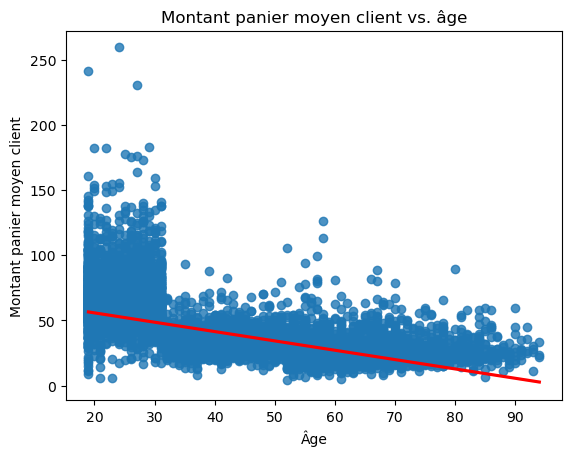

Coefficient de corrélation de Spearman : -0.7005506386611035
Valeur p : 0.0

Les variables sont corrélées (on rejette H0)


In [115]:
# 1 observation = 1 client
# Visualisation de la tendance
sb.regplot(data=data, x="age", y="CA_moy", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Montant panier moyen client")
plt.title("Montant panier moyen client vs. âge")
plt.savefig("Paniermoy_age.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["CA_moy"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

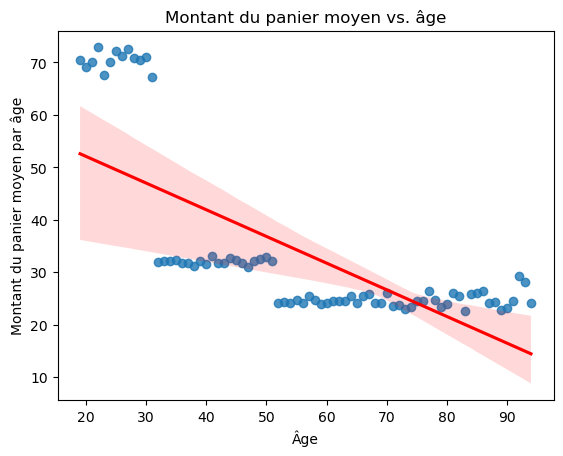

Coefficient de corrélation de Spearman : -0.7005506386611035
Valeur p : 0.0

Les variables sont corrélées (on rejette H0)


In [116]:
# 1 observation = 1 âge
# Il faut regrouper les données par âge
data_tmp = df_CA_sess.merge(df_clients_corr, how='inner', left_on='client_id', right_on='client_id')
data_age = data_tmp.groupby("age")["CA"].mean().reset_index().sort_values("age",ascending=True)
data_age.rename(columns={"CA": "CA_moy"}, inplace=True)

# Visualisation de la tendance
sb.regplot(data=data_age, x="age", y="CA_moy", robust=True, line_kws={'color': "r"})
plt.xlabel("Âge")
plt.ylabel("Montant du panier moyen par âge")
plt.title("Montant du panier moyen vs. âge")
plt.savefig("CAmoy_age_moyen.png")
plt.show()

# Calculer le coefficient de corrélation de Spearman et la valeur p
spearman_corr, spearman_p_value = st.spearmanr(data["age"], data["CA_moy"])

print(f"Coefficient de corrélation de Spearman : {spearman_corr}")
print(f"Valeur p : {spearman_p_value}")

# Interprétation des résultats
alpha = 0.05
if spearman_p_value > alpha:
    print("\nLes variables ne sont pas corrélées (on ne rejette pas H0)")
else:
    print("\nLes variables sont corrélées (on rejette H0)")

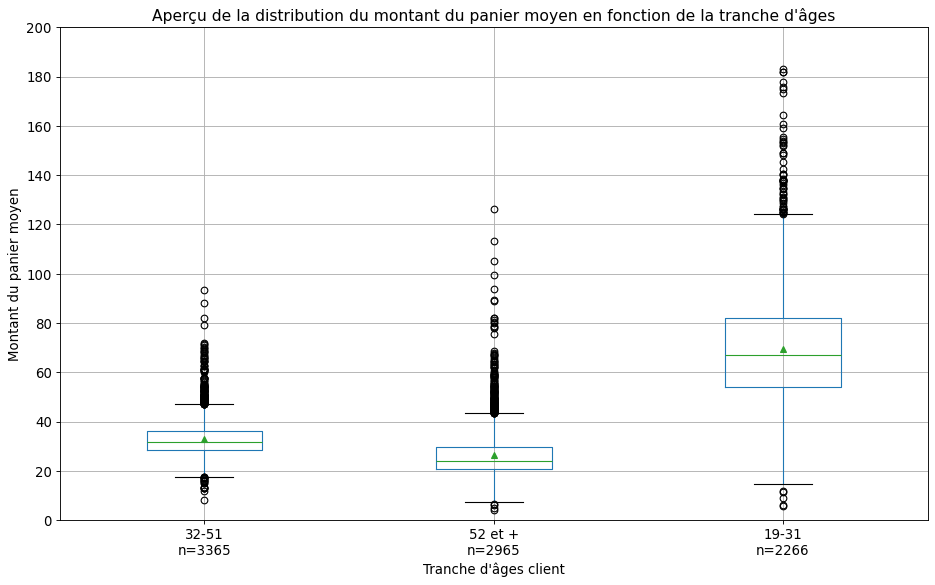

In [117]:
# Corrélation en substituant l'âge par la tranche d'âge
# 1 observation = 1 client

# Boîtes à moustaches pour l'analyse des prix selon la catégorie des produits
L_tranche = list(data.groupby('tranche').count().sort_values("CA_moy",ascending=False).index)

fig = plt.figure(figsize=(14,8), dpi=80)

for i in np.arange(len(L_tranche)):
    tranche = L_tranche[i]
    data.loc[data["tranche"] == tranche].boxplot(column=["CA_moy"], positions=[i], widths=[0.4], showmeans=True)
    L_tranche[i] = tranche + "\n" + "n="+str(len(data.loc[data["tranche"] == tranche]))

plt.xticks(ticks=np.arange(len(L_tranche)), labels=L_tranche, fontsize=12)
plt.xlabel("Tranche d'âges client", fontsize=12)
plt.ylabel("Montant du panier moyen", fontsize=12)
plt.xlim([-0.5,len(L_tranche)-0.5])
plt.ylim([0,200])
plt.yticks(ticks=np.linspace(0,200,11),fontsize=12)
plt.title("Aperçu de la distribution du montant du panier moyen en fonction de la tranche d'âges", fontsize=14)
plt.savefig("CAmoy_trancheage.png")
plt.show()

In [118]:
# Test H de Kruskal-Wallis pour déceler un éventuel effet statistque de la tranche d'âges sur la taille du panier moyen
# Hypothèse H0 : les tailles de panier moyen des différentes tranches d'âges proviennent de la même distribution
# Hypothèse H1 : la tranche d'âges a un impact sur la taille du panier moyen
   
data = data.sort_values(by="CA_moy", ascending=True)

H, p = st.kruskal(data.loc[data["tranche"] == "19-31"]["CA_moy"],\
                  data.loc[data["tranche"] == "32-51"]["CA_moy"],\
                  data.loc[data["tranche"] == "52 et +"]["CA_moy"])

print("Statistique H =",H)
print(f"Valeur p : {p}")

# Interprétation des résultats
alpha = 0.05
if p > alpha:
    print("Les montants de panier moyen des clients des différentes tranches d'âges proviennent de la même distribution (on ne rejette pas H0)")
else:
    print("Les montants de panier moyen des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)")

Statistique H = 5067.0408633317
Valeur p : 0.0
Les montants de panier moyen des clients des différentes tranches d'âges ne proviennent pas de la même distribution (on rejette H0)
